# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


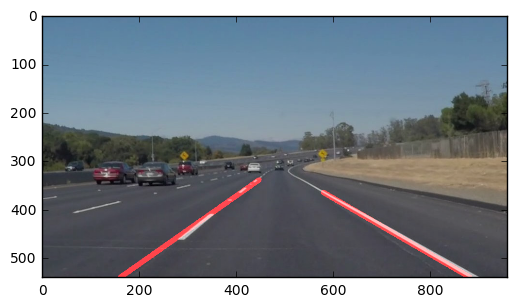

In [7]:
#reading in an image

image = mpimg.imread('test_images/solidWhiteCurve.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(process_image(image))  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image


**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
import math

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

 
    print('This image is:', type(image), 'with dimesions:', image.shape)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    edges = cv2.Canny(blur_gray,50,150)

    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450, 325), (490, 325), (imshape[1],imshape[0])]], dtype=np.int32)
    roi = region_of_interest(edges,vertices)
    rho = 2# distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap = 40    # maximum gap in pixels between connectable line segments


    line_image = hough_lines(roi, rho, theta, threshold, min_line_length, max_line_gap)

    result = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
    return result


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    x1LeftAvg = 0
    x2LeftAvg = 0
    y1LeftAvg = 0
    y2LeftAvg = 0
    x1RightAvg = 0
    x2RightAvg = 0
    y1RightAvg = 0
    y2RightAvg = 0
    countL = 0
    countR = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            angle = np.arctan2(y2-y1, x2-x1) * 180 / np.pi;
            if np.absolute(angle) < 29:
                continue
            if np.absolute(angle) > 39:
                continue
            found = 1
            if angle > 0:
                x1RightAvg += x1
                x2RightAvg +=x2
                y1RightAvg +=y1
                y2RightAvg +=y2
                countR+=1
            else:
                x1LeftAvg += x1
                x2LeftAvg +=x2
                y1LeftAvg +=y1
                y2LeftAvg +=y2
                countL+=1
    if countR ==0:
        return
    if countL ==0:
        return
    x1RightAvg = int(x1RightAvg/countR)
    x2RightAvg =int(x2RightAvg/countR)
    y1RightAvg =int(y1RightAvg/countR)
    y2RightAvg =int(y2RightAvg/countR)
    x1LeftAvg = int(x1LeftAvg/countL)
    x2LeftAvg =int(x2LeftAvg/countL)
    y1LeftAvg =int(y1LeftAvg/countL)
    y2LeftAvg =int(y2LeftAvg/countL)
 
    if found ==1 :
        angleAvgR = np.arctan2(y2RightAvg-y1RightAvg,x2RightAvg-x1RightAvg)
        angleAvgL = np.arctan2(y2LeftAvg-y1LeftAvg,x2LeftAvg-x1LeftAvg)
        hL = img.shape[0] - y2LeftAvg
        hR = img.shape[0] - y1RightAvg
        distAvgL = hL/(np.tan(np.absolute(angleAvgL)))
        distAvgR = hR/(np.tan(np.absolute(angleAvgR)))
        lenLeft = int(np.sin(np.absolute(angleAvgL)) * 350)
        lenRight = int(np.sin(np.absolute(angleAvgR)) * 350)
        latLeft = int(np.cos(np.absolute(angleAvgL)) * 350)
        latRight = int(np.cos(np.absolute(angleAvgR)) * 350)
        xleft =  int(x2LeftAvg - distAvgL)
        bottom= int(img.shape[0])
        xright = int(x1RightAvg + distAvgR)
        xL = latLeft + xleft
        yL = bottom - lenLeft
        xR = xright - latRight
        yR = bottom - lenRight
        xLA = int(x2LeftAvg - distAvgL)
        xRA = int(x1RightAvg +distAvgR)
        cv2.line(img, (xLA, bottom), (xL, yL), color, thickness)
        cv2.line(img, (xRA, bottom), (xR, yR), color, thickness)
  
        
        #cv2.line(img, (xright, yleft), (x1Left, y1Left), color, thickness)
        #cv2.line(img, (xleft, yleft), (x2Right, y2Right), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [150]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [151]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [5]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  5%|▌         | 12/222 [00:00<00:01, 117.60it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr

 18%|█▊        | 40/222 [00:00<00:01, 124.26it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr

 27%|██▋       | 59/222 [00:00<00:01, 99.07it/s] 

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr

 35%|███▍      | 77/222 [00:00<00:01, 89.70it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr

 43%|████▎     | 96/222 [00:00<00:01, 88.06it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr

 52%|█████▏    | 116/222 [00:01<00:01, 89.24it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr

 56%|█████▋    | 125/222 [00:01<00:01, 78.14it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 64%|██████▍   | 143/222 [00:01<00:01, 78.75it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr

 72%|███████▏  | 160/222 [00:01<00:00, 73.77it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr

 79%|███████▉  | 176/222 [00:02<00:00, 71.71it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr

 87%|████████▋ | 193/222 [00:02<00:00, 76.97it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr

 95%|█████████▍| 210/222 [00:02<00:00, 80.56it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr

100%|█████████▉| 221/222 [00:02<00:00, 85.27it/s]


This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2.08 s, sys: 601 ms, total: 2.68 s
Wall time: 3 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [6]:
HTML("""
<video wid|th="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [331]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

  self.nchannels))



This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4





  0%|          | 0/682 [00:00<?, ?it/s]


  1%|▏         | 10/682 [00:00<00:07, 91.87it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




  3%|▎         | 21/682 [00:00<00:06, 96.07it/s]


  5%|▍         | 31/682 [00:00<00:06, 96.94it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




  6%|▌         | 42/682 [00:00<00:06, 98.54it/s]


  7%|▋         | 50/682 [00:00<00:07, 79.35it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)





  9%|▊         | 58/682 [00:00<00:08, 75.78it/s]


 10%|▉         | 66/682 [00:00<00:08, 76.83it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 11%|█         | 74/682 [00:00<00:07, 76.48it/s]


 12%|█▏        | 82/682 [00:01<00:08, 72.69it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 13%|█▎        | 90/682 [00:01<00:08, 65.91it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)





 14%|█▍        | 97/682 [00:01<00:09, 64.54it/s]


 15%|█▌        | 104/682 [00:01<00:08, 65.45it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 16%|█▋        | 112/682 [00:01<00:08, 66.41it/s]


 18%|█▊        | 121/682 [00:01<00:07, 70.98it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 19%|█▉        | 129/682 [00:01<00:07, 72.31it/s]


 20%|██        | 137/682 [00:01<00:07, 71.73it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 21%|██▏       | 145/682 [00:01<00:07, 70.74it/s]


 22%|██▏       | 153/682 [00:02<00:07, 71.81it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 24%|██▎       | 161/682 [00:02<00:07, 73.37it/s]


 25%|██▍       | 169/682 [00:02<00:06, 74.70it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 26%|██▌       | 178/682 [00:02<00:06, 77.54it/s]


 27%|██▋       | 187/682 [00:02<00:06, 78.62it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 29%|██▊       | 195/682 [00:02<00:06, 78.24it/s]


 30%|██▉       | 203/682 [00:02<00:06, 78.63it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 31%|███       | 211/682 [00:02<00:05, 78.89it/s]


 32%|███▏      | 220/682 [00:02<00:05, 80.09it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 34%|███▎      | 229/682 [00:02<00:05, 80.00it/s]


 35%|███▍      | 238/682 [00:03<00:05, 74.97it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 36%|███▌      | 246/682 [00:03<00:05, 74.84it/s]


 37%|███▋      | 254/682 [00:03<00:05, 76.18it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 39%|███▊      | 263/682 [00:03<00:05, 77.44it/s]


 40%|███▉      | 271/682 [00:03<00:05, 77.69it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 41%|████      | 280/682 [00:03<00:05, 78.95it/s]


 42%|████▏     | 288/682 [00:03<00:05, 78.43it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 43%|████▎     | 296/682 [00:03<00:04, 78.47it/s]


 45%|████▍     | 306/682 [00:03<00:04, 80.98it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 46%|████▌     | 315/682 [00:04<00:04, 79.50it/s]


 48%|████▊     | 324/682 [00:04<00:04, 80.81it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 49%|████▉     | 333/682 [00:04<00:04, 79.24it/s]


 50%|█████     | 341/682 [00:04<00:04, 79.30it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 51%|█████     | 349/682 [00:04<00:04, 79.09it/s]


 52%|█████▏    | 357/682 [00:04<00:04, 79.23it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 54%|█████▎    | 365/682 [00:04<00:04, 79.10it/s]


 55%|█████▍    | 373/682 [00:04<00:03, 78.56it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 56%|█████▌    | 381/682 [00:04<00:03, 78.69it/s]


 57%|█████▋    | 389/682 [00:05<00:03, 78.49it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 58%|█████▊    | 397/682 [00:05<00:03, 76.89it/s]


 60%|█████▉    | 406/682 [00:05<00:03, 78.10it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 61%|██████    | 414/682 [00:05<00:03, 75.75it/s]


 62%|██████▏   | 423/682 [00:05<00:03, 77.91it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 63%|██████▎   | 431/682 [00:05<00:03, 76.45it/s]


 65%|██████▍   | 440/682 [00:05<00:03, 78.19it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 66%|██████▌   | 448/682 [00:05<00:03, 77.78it/s]


 67%|██████▋   | 456/682 [00:05<00:02, 78.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 68%|██████▊   | 464/682 [00:06<00:02, 78.65it/s]


 69%|██████▉   | 472/682 [00:06<00:02, 78.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 71%|███████   | 481/682 [00:06<00:02, 79.21it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 72%|███████▏  | 489/682 [00:06<00:02, 77.49it/s]


 73%|███████▎  | 498/682 [00:06<00:02, 77.94it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 74%|███████▍  | 506/682 [00:06<00:02, 76.12it/s]


 75%|███████▌  | 514/682 [00:06<00:02, 75.44it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 77%|███████▋  | 522/682 [00:06<00:02, 74.67it/s]


 78%|███████▊  | 530/682 [00:06<00:02, 75.30it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 79%|███████▉  | 538/682 [00:06<00:01, 74.80it/s]


 80%|████████  | 546/682 [00:07<00:01, 76.15it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 81%|████████▏ | 555/682 [00:07<00:01, 77.67it/s]


 83%|████████▎ | 563/682 [00:07<00:01, 75.84it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 84%|████████▎ | 571/682 [00:07<00:01, 74.63it/s]


 85%|████████▍ | 579/682 [00:07<00:01, 73.93it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 86%|████████▌ | 587/682 [00:07<00:01, 72.17it/s]


 87%|████████▋ | 595/682 [00:07<00:01, 74.31it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 88%|████████▊ | 603/682 [00:07<00:01, 74.02it/s]


 90%|████████▉ | 611/682 [00:07<00:00, 75.61it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 91%|█████████ | 619/682 [00:08<00:00, 75.23it/s]


 92%|█████████▏| 627/682 [00:08<00:00, 75.35it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 93%|█████████▎| 635/682 [00:08<00:00, 76.21it/s]


 94%|█████████▍| 643/682 [00:08<00:00, 76.76it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 95%|█████████▌| 651/682 [00:08<00:00, 75.25it/s]


 97%|█████████▋| 659/682 [00:08<00:00, 76.28it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




 98%|█████████▊| 667/682 [00:08<00:00, 75.21it/s]


 99%|█████████▉| 675/682 [00:08<00:00, 75.38it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarr




100%|█████████▉| 681/682 [00:08<00:00, 76.73it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 6.68 s, sys: 2.35 s, total: 9.03 s
Wall time: 9.29 s


In [319]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!




# My reflections:

I think my algorithm works pretty well, but there are some cases where it will fail, like in the challenge video.
The issue appears when there are other lines that are included in the average/extrapolate which they shouldn't:
They meet my angle criteria, but they are in a different zone. Now if those lines/shapes are near the lines that I should detect, that doesn't affect the algorithm too much(like in the solid yellow left video), but still it could be improved.
One way to improve is to select only those lines that when extrapolated with others form a line with a similar angle from the defined criteria.
    
    

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [302]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

  self.nchannels))



This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 774 0
tempsfdvdvdfv 1817 1
tempsfdvdvdfv 2560 2
tempsfdvdvdfv 3379 3
tempsfdvdvdfv 4401 4
tempsfdvdvdfv 5144 5
tempsfdvdvdfv 6217 6
tempsfdvdvdfv 7038 7
tempsfdvdvdfv 7710 8
tempsfdvdvdfv 8806 9
tempsfdvdvdfv 9255 10
tempsfdvdvdfv 10073 11
tempsfdvdvdfv 10562 12
tempsfdvdvdfv 11233 13
tempsfdvdvdfv 11954 14
tempsfdvdvdfv 12994 15
tempsfdvdvdfv 13521 16
tempsfdvdvdfv 14174 17
tempsfdvdvdfv 14854 18
avg 19 10 705 781 464 512 370 455 602 545
left [[754, 479, 774, 491], [930, 580, 1043, 647], [646, 408, 743, 466], [722, 454, 819, 517], [913, 579, 1022, 647], [641, 401, 743, 465], [995, 629, 1073, 677], [674, 417, 821, 520], [630, 407, 672, 432], [976, 608, 1096, 675], [399, 371, 449, 401], [723, 456, 818, 520], [402, 378, 489, 430], [630, 409, 671, 433], [688, 426, 721, 448], [988, 625, 1040, 658], [414, 379, 527, 455], [629, 405, 653, 420], [645, 405, 680, 427]]
right [[281, 685, 441, 569], [253, 686, 504,




  0%|          | 0/251 [00:00<?, ?it/s]


  2%|▏         | 5/251 [00:00<00:05, 45.52it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 774 0
tempsfdvdvdfv 1817 1
tempsfdvdvdfv 2560 2
tempsfdvdvdfv 3379 3
tempsfdvdvdfv 4401 4
tempsfdvdvdfv 5144 5
tempsfdvdvdfv 6217 6
tempsfdvdvdfv 7038 7
tempsfdvdvdfv 7710 8
tempsfdvdvdfv 8806 9
tempsfdvdvdfv 9255 10
tempsfdvdvdfv 10073 11
tempsfdvdvdfv 10562 12
tempsfdvdvdfv 11233 13
tempsfdvdvdfv 11954 14
tempsfdvdvdfv 12994 15
tempsfdvdvdfv 13521 16
tempsfdvdvdfv 14174 17
tempsfdvdvdfv 14854 18
avg 19 10 705 781 464 512 370 455 602 545
left [[754, 479, 774, 491], [930, 580, 1043, 647], [646, 408, 743, 466], [722, 454, 819, 517], [913, 579, 1022, 647], [641, 401, 743, 465], [995, 629, 1073, 677], [674, 417, 821, 520], [630, 407, 672, 432], [976, 608, 1096, 675], [399, 371, 449, 401], [723, 456, 818, 520], [402, 378, 489, 430], [630, 409, 671, 433], [688, 426, 721, 448], [988, 625, 1040, 658], [414, 379, 527, 455], [629, 405, 653, 420], [645, 405, 680, 427]]
right [[281, 685, 441, 569], [253, 686, 504,




  4%|▍         | 10/251 [00:00<00:05, 45.89it/s]


  6%|▌         | 15/251 [00:00<00:05, 45.42it/s]

tempsfdvdvdfv 673 0
tempsfdvdvdfv 1467 1
tempsfdvdvdfv 2400 2
tempsfdvdvdfv 3127 3
tempsfdvdvdfv 4074 4
tempsfdvdvdfv 4748 5
tempsfdvdvdfv 5697 6
tempsfdvdvdfv 6570 7
tempsfdvdvdfv 7358 8
tempsfdvdvdfv 8031 9
tempsfdvdvdfv 8508 10
tempsfdvdvdfv 9453 11
tempsfdvdvdfv 10209 12
tempsfdvdvdfv 11146 13
tempsfdvdvdfv 11997 14
tempsfdvdvdfv 12677 15
tempsfdvdvdfv 13302 16
tempsfdvdvdfv 13866 17
tempsfdvdvdfv 14731 18
avg 19 15 726 775 470 502 480 566 521 461
left [[617, 397, 673, 429], [723, 455, 794, 498], [842, 534, 933, 593], [642, 401, 727, 454], [867, 542, 947, 593], [617, 395, 674, 429], [907, 565, 949, 592], [852, 533, 873, 547], [730, 460, 788, 499], [621, 392, 673, 434], [436, 406, 477, 432], [878, 548, 945, 593], [730, 461, 756, 480], [905, 565, 937, 586], [841, 534, 851, 541], [623, 393, 680, 429], [574, 412, 625, 446], [554, 417, 564, 423], [846, 537, 865, 550]]
right [[299, 683, 492, 538], [274, 683, 535, 501], [500, 534, 647, 424], [544, 495, 678, 420], [534, 502, 589, 471], [60




  8%|▊         | 20/251 [00:00<00:05, 46.14it/s]


 10%|▉         | 25/251 [00:00<00:04, 45.80it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 882 0
tempsfdvdvdfv 1756 1
tempsfdvdvdfv 2566 2
tempsfdvdvdfv 3434 3
tempsfdvdvdfv 4305 4
avg 5 14 787 861 501 546 404 485 537 478
left [[738, 468, 882, 554], [809, 516, 874, 555], [768, 490, 810, 514], [813, 514, 868, 554], [811, 518, 871, 555]]
right [[299, 684, 645, 423], [275, 685, 470, 544], [498, 526, 550, 489], [302, 683, 376, 627], [465, 549, 499, 524], [353, 439, 443, 376], [545, 500, 644, 423], [343, 440, 354, 432], [515, 515, 555, 486], [376, 499, 390, 491], [362, 439, 471, 366], [441, 566, 466, 547], [439, 433, 474, 409], [446, 572, 460, 562]]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 913 0
tempsfdvdvdfv 1816 1
tempsfdvdvdfv 2598 2
tempsfdvdvdfv 3355 3
tempsfdvdvdfv 4231 4
tempsfdvdvdfv 4982 5
tempsfdvdvdfv 5738 6
tempsfdvdvdfv 6473 7
tempsfdvdvdfv 7375 8
tempsfdvdvdfv 8109 9
tempsfdvdvdfv 8780 10
tempsfdvdvdfv 9693 11
tempsfdvdvdfv 10428 12
tempsfdv




 12%|█▏        | 30/251 [00:00<00:04, 45.90it/s]


 14%|█▍        | 35/251 [00:00<00:04, 46.02it/s]

tempsfdvdvdfv 824 0
tempsfdvdvdfv 1638 1
tempsfdvdvdfv 2291 2
tempsfdvdvdfv 2721 3
tempsfdvdvdfv 3450 4
tempsfdvdvdfv 4268 5
tempsfdvdvdfv 5084 6
tempsfdvdvdfv 5908 7
tempsfdvdvdfv 6725 8
tempsfdvdvdfv 7259 9
avg 10 10 651 725 433 481 349 458 569 492
left [[734, 464, 824, 518], [779, 497, 814, 520], [551, 365, 653, 439], [414, 368, 430, 380], [535, 347, 729, 455], [693, 426, 818, 520], [724, 455, 816, 520], [783, 495, 824, 519], [785, 500, 817, 520], [520, 418, 534, 426]]
right [[321, 647, 548, 488], [292, 685, 579, 469], [385, 601, 532, 498], [275, 682, 337, 636], [321, 439, 429, 361], [596, 465, 660, 419], [295, 684, 334, 655], [362, 408, 424, 373], [288, 672, 303, 660], [361, 409, 434, 363]]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 673 0
tempsfdvdvdfv 1485 1
tempsfdvdvdfv 2326 2
tempsfdvdvdfv 3157 3
tempsfdvdvdfv 3996 4
tempsfdvdvdfv 4661 5
tempsfdvdvdfv 5177 6
tempsfdvdvdfv 5824 7
tempsfdvdvdfv 6266 8
tempsfdvdvdfv 7107 9
tempsfdvdvdfv 755




 16%|█▌        | 40/251 [00:00<00:04, 45.67it/s]


 18%|█▊        | 45/251 [00:00<00:04, 46.32it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 803 0
tempsfdvdvdfv 1476 1
tempsfdvdvdfv 2273 2
tempsfdvdvdfv 2941 3
tempsfdvdvdfv 3616 4
tempsfdvdvdfv 4338 5
tempsfdvdvdfv 5133 6
tempsfdvdvdfv 5786 7
tempsfdvdvdfv 6315 8
tempsfdvdvdfv 7061 9
tempsfdvdvdfv 7787 10
tempsfdvdvdfv 8845 11
tempsfdvdvdfv 9913 12
tempsfdvdvdfv 10462 13
tempsfdvdvdfv 11263 14
tempsfdvdvdfv 12310 15
tempsfdvdvdfv 12976 16
tempsfdvdvdfv 13611 17
tempsfdvdvdfv 14281 18
avg 19 17 690 751 443 483 387 470 579 525
left [[746, 473, 803, 505], [620, 403, 673, 434], [746, 474, 797, 507], [605, 398, 668, 434], [575, 372, 675, 434], [686, 423, 722, 447], [685, 424, 795, 507], [492, 332, 653, 440], [495, 328, 529, 349], [727, 460, 746, 472], [690, 427, 726, 452], [1029, 657, 1058, 677], [1053, 668, 1068, 678], [503, 342, 549, 368], [679, 419, 801, 507], [1031, 657, 1047, 668], [638, 418, 666, 434], [518, 357, 635, 436], [608, 399, 670, 434]]
right [[282, 685, 510, 520], [560, 487, 678, 




 20%|█▉        | 50/251 [00:01<00:05, 39.10it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 1036 0
tempsfdvdvdfv 1721 1
tempsfdvdvdfv 2347 2
tempsfdvdvdfv 3169 3
tempsfdvdvdfv 4101 4
tempsfdvdvdfv 5173 5
tempsfdvdvdfv 5819 6
tempsfdvdvdfv 6914 7
tempsfdvdvdfv 7638 8
tempsfdvdvdfv 8685 9
tempsfdvdvdfv 9455 10
tempsfdvdvdfv 10211 11
tempsfdvdvdfv 11156 12
tempsfdvdvdfv 11789 13
tempsfdvdvdfv 12406 14
avg 15 24 744 827 477 530 428 496 547 501
left [[917, 574, 1036, 640], [558, 363, 685, 436], [451, 343, 626, 452], [642, 406, 822, 518], [905, 577, 932, 592], [1036, 654, 1072, 677], [576, 394, 646, 441], [1018, 632, 1095, 675], [709, 436, 724, 446], [1017, 642, 1047, 662], [678, 420, 770, 492], [694, 428, 756, 478], [920, 586, 945, 600], [484, 350, 633, 450], [560, 360, 617, 394]]
right [[541, 505, 666, 415], [364, 631, 474, 553], [265, 685, 587, 468], [580, 481, 675, 420], [484, 544, 538, 507], [288, 685, 344, 647], [261, 686, 560, 485], [660, 438, 682, 424], [355, 587, 369, 579], [451, 568, 478, 




 22%|██▏       | 54/251 [00:01<00:05, 37.39it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 685 0
tempsfdvdvdfv 1509 1
tempsfdvdvdfv 2343 2
tempsfdvdvdfv 2907 3
tempsfdvdvdfv 3734 4
tempsfdvdvdfv 4422 5
tempsfdvdvdfv 5068 6
tempsfdvdvdfv 5797 7
tempsfdvdvdfv 6748 8
tempsfdvdvdfv 7384 9
tempsfdvdvdfv 8027 10
tempsfdvdvdfv 8650 11
tempsfdvdvdfv 9448 12
tempsfdvdvdfv 10010 13
tempsfdvdvdfv 10667 14
tempsfdvdvdfv 11295 15
tempsfdvdvdfv 11986 16
tempsfdvdvdfv 12809 17
tempsfdvdvdfv 13747 18
avg 19 21 631 723 419 479 432 498 536 489
left [[635, 409, 685, 438], [692, 428, 824, 527], [758, 481, 834, 525], [484, 326, 564, 374], [792, 507, 827, 527], [633, 406, 688, 438], [467, 326, 646, 442], [632, 402, 729, 456], [916, 676, 951, 704], [532, 379, 636, 449], [542, 382, 643, 445], [467, 357, 623, 454], [658, 414, 798, 505], [492, 328, 562, 375], [474, 325, 657, 439], [506, 353, 628, 441], [672, 426, 691, 438], [725, 448, 823, 527], [927, 591, 938, 598]]
right [[347, 645, 664, 414], [268, 685, 409, 587], 




 23%|██▎       | 58/251 [00:01<00:05, 35.43it/s]

tempsfdvdvdfv 864 0
tempsfdvdvdfv 1738 1
tempsfdvdvdfv 2609 2
tempsfdvdvdfv 3221 3
tempsfdvdvdfv 4041 4
tempsfdvdvdfv 4714 5
tempsfdvdvdfv 5266 6
tempsfdvdvdfv 6334 7
tempsfdvdvdfv 7104 8
tempsfdvdvdfv 7686 9
tempsfdvdvdfv 8547 10
tempsfdvdvdfv 9048 11
tempsfdvdvdfv 9733 12
tempsfdvdvdfv 10602 13
tempsfdvdvdfv 11161 14
avg 15 13 663 744 445 496 426 539 567 488
left [[826, 529, 864, 552], [741, 469, 874, 552], [812, 513, 871, 547], [421, 350, 612, 456], [697, 429, 820, 525], [629, 412, 673, 438], [481, 328, 552, 368], [1041, 661, 1068, 677], [693, 428, 770, 490], [470, 406, 582, 471], [807, 513, 861, 551], [417, 380, 501, 430], [658, 409, 685, 429], [819, 516, 869, 552], [445, 336, 559, 413]]
right [[293, 684, 661, 416], [270, 684, 498, 525], [475, 550, 662, 414], [451, 559, 514, 514], [613, 442, 658, 410], [272, 682, 371, 613], [455, 565, 591, 466], [531, 504, 550, 491], [517, 512, 680, 421], [295, 683, 321, 665], [411, 587, 474, 542], [509, 519, 529, 504], [447, 406, 502, 363]]
This i

tempsfdvdvdfv 544 0
tempsfdvdvdfv 1484 1
tempsfdvdvdfv 2557 2
tempsfdvdvdfv 3230 3
tempsfdvdvdfv 3851 4
tempsfdvdvdfv 4391 5
tempsfdvdvdfv 5204 6
tempsfdvdvdfv 6132 7
tempsfdvdvdfv 6939 8
tempsfdvdvdfv 7987 9
tempsfdvdvdfv 8924 10
tempsfdvdvdfv 10010 11
tempsfdvdvdfv 10964 12
tempsfdvdvdfv 11500 13
tempsfdvdvdfv 12069 14
tempsfdvdvdfv 13156 15
tempsfdvdvdfv 13698 16
tempsfdvdvdfv 14238 17
tempsfdvdvdfv 14904 18
tempsfdvdvdfv 15886 19
tempsfdvdvdfv 16366 20
tempsfdvdvdfv 17044 21
tempsfdvdvdfv 17585 22
tempsfdvdvdfv 18211 23
tempsfdvdvdfv 19016 24
tempsfdvdvdfv 19587 25
tempsfdvdvdfv 20677 26
avg 27 34 687 765 459 509 464 535 506 459
left [[485, 325, 544, 360], [881, 561, 940, 599], [955, 608, 1073, 677], [622, 411, 673, 440], [462, 335, 621, 455], [474, 328, 540, 365], [728, 456, 813, 509], [896, 561, 928, 581], [754, 477, 807, 513], [1006, 639, 1048, 663], [926, 589, 937, 597], [978, 608, 1086, 675], [944, 600, 954, 607], [429, 346, 536, 430], [461, 403, 569, 479], [1040, 645, 1087, 6




 25%|██▍       | 62/251 [00:01<00:05, 34.67it/s]

tempsfdvdvdfv 1065 0
tempsfdvdvdfv 2134 1
tempsfdvdvdfv 3226 2
tempsfdvdvdfv 4027 3
tempsfdvdvdfv 4661 4
tempsfdvdvdfv 5326 5
tempsfdvdvdfv 5927 6
tempsfdvdvdfv 6438 7
tempsfdvdvdfv 6982 8
tempsfdvdvdfv 7681 9
tempsfdvdvdfv 8295 10
tempsfdvdvdfv 8824 11
tempsfdvdvdfv 9334 12
tempsfdvdvdfv 9947 13
tempsfdvdvdfv 10547 14
tempsfdvdvdfv 11230 15
tempsfdvdvdfv 11839 16
tempsfdvdvdfv 12627 17
tempsfdvdvdfv 13368 18
tempsfdvdvdfv 14052 19
tempsfdvdvdfv 14697 20
tempsfdvdvdfv 15379 21
tempsfdvdvdfv 16073 22
avg 23 20 593 698 408 474 402 489 569 508
left [[1012, 640, 1065, 676], [1013, 640, 1069, 676], [1000, 621, 1092, 674], [648, 406, 801, 501], [454, 333, 634, 449], [460, 326, 665, 440], [445, 362, 601, 464], [451, 364, 511, 398], [440, 334, 544, 399], [646, 406, 699, 440], [431, 342, 614, 452], [488, 332, 529, 355], [407, 372, 510, 453], [437, 339, 613, 458], [416, 362, 600, 464], [664, 429, 683, 440], [499, 384, 609, 459], [776, 491, 788, 498], [613, 390, 741, 461], [618, 402, 684, 440], [




 26%|██▋       | 66/251 [00:01<00:05, 34.75it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 889 0
tempsfdvdvdfv 1767 1
tempsfdvdvdfv 2656 2
tempsfdvdvdfv 3165 3
tempsfdvdvdfv 3758 4
tempsfdvdvdfv 4366 5
tempsfdvdvdfv 4848 6
tempsfdvdvdfv 5724 7
tempsfdvdvdfv 6347 8
tempsfdvdvdfv 6775 9
tempsfdvdvdfv 7624 10
tempsfdvdvdfv 8103 11
tempsfdvdvdfv 8886 12
tempsfdvdvdfv 9439 13
tempsfdvdvdfv 10088 14
tempsfdvdvdfv 10692 15
tempsfdvdvdfv 11537 16
avg 17 25 571 678 411 484 398 474 543 491
left [[639, 399, 889, 555], [639, 400, 878, 555], [826, 515, 889, 554], [382, 386, 509, 459], [439, 346, 593, 466], [446, 336, 608, 462], [448, 369, 482, 388], [847, 537, 876, 555], [542, 397, 623, 454], [388, 404, 428, 433], [680, 420, 849, 538], [386, 386, 479, 459], [746, 469, 783, 490], [419, 358, 553, 456], [605, 407, 649, 433], [446, 335, 604, 445], [835, 528, 845, 535]]
right [[303, 657, 518, 512], [289, 684, 451, 567], [431, 572, 573, 477], [259, 685, 324, 644], [523, 516, 650, 433], [346, 438, 501, 345], [45




 28%|██▊       | 70/251 [00:01<00:05, 34.07it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 704 0
tempsfdvdvdfv 1509 1
tempsfdvdvdfv 2512 2
tempsfdvdvdfv 3520 3
tempsfdvdvdfv 4440 4
tempsfdvdvdfv 5446 5
tempsfdvdvdfv 6251 6
tempsfdvdvdfv 6781 7
tempsfdvdvdfv 7593 8
tempsfdvdvdfv 8112 9
tempsfdvdvdfv 8924 10
tempsfdvdvdfv 9549 11
tempsfdvdvdfv 10012 12
tempsfdvdvdfv 10616 13
tempsfdvdvdfv 11416 14
tempsfdvdvdfv 12374 15
avg 16 22 668 773 447 512 419 512 526 462
left [[638, 404, 704, 445], [754, 476, 805, 505], [870, 551, 1003, 631], [921, 572, 1008, 621], [884, 549, 920, 571], [870, 550, 1006, 631], [692, 426, 805, 508], [411, 360, 530, 434], [655, 408, 812, 506], [413, 366, 519, 440], [714, 446, 812, 507], [440, 344, 625, 455], [415, 358, 463, 386], [417, 362, 604, 466], [681, 421, 800, 507], [922, 572, 958, 592]]
right [[547, 503, 667, 416], [277, 682, 501, 526], [602, 448, 654, 408], [362, 636, 442, 579], [529, 507, 666, 431], [479, 552, 652, 417], [295, 684, 390, 617], [556, 490, 675, 421],




 29%|██▉       | 74/251 [00:01<00:05, 32.92it/s]

tempsfdvdvdfv 625 0
tempsfdvdvdfv 1418 1
tempsfdvdvdfv 2500 2
tempsfdvdvdfv 3295 3
tempsfdvdvdfv 4344 4
tempsfdvdvdfv 5138 5
tempsfdvdvdfv 6212 6
tempsfdvdvdfv 6792 7
tempsfdvdvdfv 7395 8
tempsfdvdvdfv 7906 9
tempsfdvdvdfv 8635 10
tempsfdvdvdfv 9236 11
tempsfdvdvdfv 9987 12
tempsfdvdvdfv 10591 13
tempsfdvdvdfv 11319 14
tempsfdvdvdfv 12426 15
tempsfdvdvdfv 13456 16
tempsfdvdvdfv 14101 17
avg 18 24 707 783 480 533 421 517 525 456
left [[434, 345, 625, 455], [770, 486, 793, 500], [989, 616, 1082, 676], [693, 426, 795, 500], [1013, 619, 1049, 641], [678, 419, 794, 500], [1034, 644, 1074, 669], [411, 363, 580, 482], [457, 346, 603, 464], [431, 393, 511, 445], [704, 432, 729, 447], [455, 347, 601, 465], [698, 432, 751, 472], [557, 670, 604, 700], [703, 432, 728, 447], [1068, 651, 1107, 674], [1005, 627, 1030, 643], [627, 404, 645, 414]]
right [[578, 479, 662, 416], [371, 636, 455, 571], [307, 683, 353, 648], [280, 684, 551, 495], [589, 477, 649, 435], [481, 553, 656, 417], [399, 370, 453, 32




 31%|███       | 78/251 [00:02<00:05, 32.59it/s]

tempsfdvdvdfv 839 0
tempsfdvdvdfv 1608 1
tempsfdvdvdfv 2227 2
tempsfdvdvdfv 2936 3
tempsfdvdvdfv 3300 4
tempsfdvdvdfv 4129 5
tempsfdvdvdfv 4699 6
tempsfdvdvdfv 5494 7
avg 8 27 600 686 435 487 401 475 499 447
left [[625, 397, 839, 521], [625, 396, 769, 479], [569, 427, 619, 458], [626, 400, 709, 450], [351, 496, 364, 506], [792, 500, 829, 522], [525, 437, 570, 465], [693, 427, 795, 501]]
right [[312, 684, 434, 589], [286, 685, 442, 572], [508, 526, 671, 420], [445, 581, 501, 541], [549, 504, 577, 486], [513, 523, 547, 501], [394, 384, 472, 325], [345, 519, 389, 493], [458, 561, 503, 531], [437, 446, 479, 414], [386, 382, 466, 326], [349, 441, 365, 430], [597, 473, 666, 418], [511, 532, 522, 525], [218, 545, 229, 537], [399, 370, 466, 325], [348, 455, 385, 429], [400, 616, 451, 578], [384, 385, 464, 329], [345, 456, 386, 430], [330, 515, 526, 393], [354, 455, 436, 406], [347, 450, 371, 434], [393, 382, 424, 358], [309, 685, 637, 438], [354, 446, 372, 434], [562, 495, 658, 433]]
This imag




 33%|███▎      | 82/251 [00:02<00:05, 31.82it/s]

tempsfdvdvdfv 793 0
tempsfdvdvdfv 1591 1
tempsfdvdvdfv 2522 2
tempsfdvdvdfv 3133 3
tempsfdvdvdfv 4062 4
tempsfdvdvdfv 4855 5
tempsfdvdvdfv 5283 6
tempsfdvdvdfv 5933 7
tempsfdvdvdfv 6583 8
tempsfdvdvdfv 7375 9
tempsfdvdvdfv 7913 10
tempsfdvdvdfv 8490 11
avg 12 21 598 707 423 492 395 492 544 476
left [[618, 393, 793, 498], [643, 401, 798, 497], [845, 530, 931, 579], [469, 358, 611, 461], [841, 529, 929, 579], [619, 390, 793, 495], [342, 433, 428, 491], [578, 391, 650, 433], [601, 420, 650, 454], [661, 413, 792, 498], [474, 396, 538, 442], [491, 424, 577, 484]]
right [[322, 680, 665, 412], [359, 636, 461, 560], [175, 569, 303, 496], [479, 547, 524, 517], [291, 684, 333, 653], [540, 504, 673, 427], [477, 560, 658, 419], [297, 684, 354, 638], [374, 460, 474, 385], [371, 461, 445, 418], [360, 635, 407, 599], [460, 562, 478, 548], [509, 526, 664, 433], [577, 451, 642, 402], [179, 569, 310, 494], [429, 437, 467, 414], [429, 504, 532, 424], [370, 461, 439, 421], [408, 438, 474, 388], [487, 453,

tempsfdvdvdfv 1096 0
tempsfdvdvdfv 2186 1
tempsfdvdvdfv 3195 2
tempsfdvdvdfv 3975 3
tempsfdvdvdfv 4805 4
tempsfdvdvdfv 5816 5
tempsfdvdvdfv 6556 6
tempsfdvdvdfv 7272 7
tempsfdvdvdfv 7813 8
tempsfdvdvdfv 8550 9
tempsfdvdvdfv 9493 10
tempsfdvdvdfv 9914 11
tempsfdvdvdfv 10696 12
tempsfdvdvdfv 11718 13
tempsfdvdvdfv 12314 14
tempsfdvdvdfv 13248 15
tempsfdvdvdfv 13512 16
tempsfdvdvdfv 14054 17
tempsfdvdvdfv 14664 18
tempsfdvdvdfv 15743 19
tempsfdvdvdfv 16251 20
avg 21 19 710 773 499 539 427 515 528 466
left [[992, 614, 1096, 674], [997, 617, 1090, 672], [915, 570, 1009, 626], [669, 415, 780, 492], [670, 418, 830, 518], [965, 599, 1011, 627], [693, 426, 740, 456], [692, 426, 716, 441], [429, 414, 541, 481], [683, 421, 737, 456], [919, 573, 943, 588], [394, 577, 421, 592], [689, 434, 782, 492], [983, 609, 1022, 633], [554, 428, 596, 461], [920, 574, 934, 583], [244, 526, 264, 538], [450, 406, 542, 461], [568, 402, 610, 430], [1037, 639, 1079, 663], [448, 403, 508, 440]]
right [[295, 684, 665,




 34%|███▍      | 86/251 [00:02<00:05, 31.37it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 818 0
tempsfdvdvdfv 1641 1
tempsfdvdvdfv 2467 2
tempsfdvdvdfv 3132 3
tempsfdvdvdfv 3806 4
tempsfdvdvdfv 4124 5
tempsfdvdvdfv 4568 6
tempsfdvdvdfv 5140 7
tempsfdvdvdfv 5745 8
tempsfdvdvdfv 5993 9
tempsfdvdvdfv 6380 10
tempsfdvdvdfv 7201 11
tempsfdvdvdfv 7583 12
avg 13 16 519 583 466 505 383 490 551 472
left [[729, 459, 818, 509], [777, 491, 823, 517], [729, 462, 826, 516], [604, 392, 665, 428], [604, 395, 674, 435], [300, 462, 318, 472], [349, 514, 444, 588], [427, 404, 572, 487], [511, 390, 605, 466], [237, 536, 248, 543], [376, 627, 387, 634], [757, 473, 821, 511], [358, 453, 382, 471]]
right [[306, 680, 526, 515], [329, 680, 491, 549], [300, 683, 435, 582], [294, 473, 349, 429], [351, 526, 377, 507], [490, 549, 598, 468], [285, 542, 323, 520], [278, 570, 357, 517], [402, 468, 538, 373], [450, 455, 497, 421], [467, 451, 498, 431], [453, 579, 517, 532], [384, 635, 596, 470], [401, 468, 485, 400], [483, 




 36%|███▌      | 90/251 [00:02<00:05, 31.14it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 879 0
tempsfdvdvdfv 1763 1
tempsfdvdvdfv 2112 2
tempsfdvdvdfv 2731 3
tempsfdvdvdfv 3616 4
tempsfdvdvdfv 3888 5
tempsfdvdvdfv 4165 6
tempsfdvdvdfv 4421 7
tempsfdvdvdfv 4820 8
tempsfdvdvdfv 5078 9
tempsfdvdvdfv 5952 10
tempsfdvdvdfv 6206 11
tempsfdvdvdfv 6482 12
avg 13 12 414 498 523 574 419 524 545 468
left [[736, 468, 879, 550], [856, 531, 884, 550], [216, 555, 349, 641], [603, 392, 619, 401], [744, 469, 885, 548], [164, 576, 272, 638], [174, 575, 277, 637], [188, 578, 256, 622], [361, 430, 399, 456], [188, 575, 258, 622], [737, 464, 874, 550], [190, 582, 254, 622], [229, 610, 276, 637]]
right [[307, 683, 582, 476], [130, 664, 363, 519], [331, 683, 587, 476], [488, 451, 549, 410], [310, 682, 389, 622], [497, 449, 551, 410], [311, 485, 430, 405], [524, 445, 545, 428], [440, 581, 525, 528], [525, 445, 546, 428], [672, 428, 683, 421], [493, 544, 543, 504]]
This image is: <class 'numpy.ndarray'> with dimesi




 37%|███▋      | 94/251 [00:02<00:05, 28.57it/s]

tempsfdvdvdfv 941 0
tempsfdvdvdfv 1729 1
tempsfdvdvdfv 2682 2
tempsfdvdvdfv 3289 3
tempsfdvdvdfv 4241 4
tempsfdvdvdfv 4629 5
tempsfdvdvdfv 4981 6
tempsfdvdvdfv 5523 7
tempsfdvdvdfv 6157 8
tempsfdvdvdfv 6916 9
tempsfdvdvdfv 7357 10
tempsfdvdvdfv 7909 11
tempsfdvdvdfv 8544 12
tempsfdvdvdfv 9205 13
tempsfdvdvdfv 9874 14
avg 15 36 582 658 452 500 315 439 578 495
left [[831, 524, 941, 587], [743, 469, 788, 494], [839, 521, 953, 587], [518, 371, 607, 443], [858, 531, 952, 585], [242, 556, 388, 637], [264, 550, 352, 601], [492, 392, 542, 431], [545, 409, 634, 476], [718, 452, 759, 476], [391, 426, 441, 455], [518, 376, 552, 398], [536, 401, 635, 476], [593, 390, 661, 436], [645, 415, 669, 432]]
right [[313, 684, 585, 479], [307, 683, 550, 500], [328, 683, 494, 553], [180, 673, 529, 464], [100, 636, 228, 559], [223, 629, 481, 480], [310, 682, 503, 536], [648, 436, 676, 419], [360, 615, 479, 544], [385, 602, 560, 480], [330, 683, 417, 615], [303, 486, 439, 383], [315, 684, 536, 517], [443, 563,

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 1096 0
tempsfdvdvdfv 1391 1
tempsfdvdvdfv 2361 2
tempsfdvdvdfv 2871 3
tempsfdvdvdfv 3485 4
tempsfdvdvdfv 3657 5
tempsfdvdvdfv 4466 6
tempsfdvdvdfv 5192 7
avg 8 16 576 649 491 534 406 488 546 489
left [[892, 557, 1096, 674], [242, 562, 295, 602], [891, 558, 970, 603], [421, 393, 510, 446], [551, 357, 614, 392], [160, 589, 172, 596], [758, 481, 809, 510], [697, 436, 726, 454]]
right [[315, 681, 558, 491], [348, 599, 621, 393], [370, 587, 406, 563], [256, 685, 321, 648], [554, 456, 618, 406], [431, 539, 510, 494], [176, 588, 192, 578], [169, 595, 197, 577], [461, 564, 509, 536], [309, 599, 425, 527], [561, 435, 615, 394], [632, 436, 662, 413], [422, 515, 484, 478], [476, 553, 523, 524], [500, 448, 568, 409], [531, 463, 611, 405]]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 685 0
tempsfdvdvdfv 1456 1
tempsfdvdvdfv 2233 2
tempsfdvdvdfv 3330 3
tempsfdvdvdfv 4368 4
temps




 39%|███▊      | 97/251 [00:02<00:05, 27.42it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 551 0
tempsfdvdvdfv 964 1
tempsfdvdvdfv 1497 2
tempsfdvdvdfv 2244 3
tempsfdvdvdfv 2675 4
tempsfdvdvdfv 3357 5
tempsfdvdvdfv 4071 6
tempsfdvdvdfv 4802 7
tempsfdvdvdfv 5470 8
tempsfdvdvdfv 6199 9
tempsfdvdvdfv 6824 10
tempsfdvdvdfv 7417 11
tempsfdvdvdfv 8217 12
avg 13 13 558 632 440 488 344 421 601 546
left [[337, 531, 551, 670], [356, 636, 413, 679], [493, 370, 533, 396], [725, 478, 747, 492], [352, 435, 431, 496], [605, 387, 682, 438], [661, 412, 714, 447], [653, 415, 731, 460], [638, 418, 668, 437], [587, 376, 729, 458], [579, 403, 625, 438], [493, 369, 593, 434], [785, 493, 800, 502]]
right [[307, 687, 532, 505], [371, 696, 457, 645], [122, 613, 132, 605], [511, 523, 532, 508], [55, 672, 142, 604], [427, 677, 503, 631], [463, 659, 473, 653], [474, 453, 536, 417], [300, 661, 312, 654], [271, 489, 420, 389], [306, 687, 472, 553], [379, 470, 456, 426], [491, 535, 516, 520]]
This image is: <class 'numpy.n




 40%|███▉      | 100/251 [00:02<00:05, 25.66it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 718 0
tempsfdvdvdfv 1541 1
tempsfdvdvdfv 2257 2
tempsfdvdvdfv 3074 3
tempsfdvdvdfv 3736 4
tempsfdvdvdfv 4422 5
tempsfdvdvdfv 4941 6
tempsfdvdvdfv 5521 7
tempsfdvdvdfv 6199 8
tempsfdvdvdfv 7011 9
tempsfdvdvdfv 7602 10
tempsfdvdvdfv 8280 11
tempsfdvdvdfv 8861 12
avg 13 25 611 681 420 464 373 455 549 491
left [[658, 410, 718, 448], [795, 499, 823, 515], [617, 388, 716, 448], [782, 494, 817, 515], [534, 348, 662, 419], [533, 349, 686, 437], [446, 419, 519, 465], [496, 388, 580, 447], [661, 496, 678, 508], [780, 496, 812, 514], [494, 374, 591, 444], [649, 414, 678, 431], [501, 387, 581, 447]]
right [[301, 684, 513, 519], [99, 637, 209, 574], [542, 440, 616, 391], [304, 683, 507, 524], [80, 662, 203, 576], [265, 590, 347, 524], [558, 438, 609, 407], [521, 441, 576, 400], [649, 436, 663, 426], [527, 440, 591, 392], [340, 475, 533, 355], [406, 616, 484, 563], [340, 661, 351, 653], [246, 593, 385, 510], [296, 48




 41%|████      | 103/251 [00:02<00:05, 26.33it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 881 0
tempsfdvdvdfv 1555 1
tempsfdvdvdfv 2241 2
tempsfdvdvdfv 2982 3
tempsfdvdvdfv 3696 4
tempsfdvdvdfv 4416 5
tempsfdvdvdfv 5120 6
tempsfdvdvdfv 5815 7
tempsfdvdvdfv 6249 8
tempsfdvdvdfv 6891 9
tempsfdvdvdfv 7329 10
tempsfdvdvdfv 7844 11
tempsfdvdvdfv 8427 12
tempsfdvdvdfv 9050 13
tempsfdvdvdfv 9558 14
tempsfdvdvdfv 10113 15
avg 16 5 553 632 407 458 293 378 602 539
left [[827, 516, 881, 547], [629, 414, 674, 439], [522, 343, 686, 438], [573, 369, 741, 466], [664, 412, 714, 442], [576, 368, 720, 451], [684, 518, 704, 533], [676, 520, 695, 534], [398, 371, 434, 395], [522, 345, 642, 438], [398, 373, 438, 400], [436, 418, 515, 467], [479, 366, 583, 447], [565, 400, 623, 439], [429, 425, 508, 469], [475, 368, 555, 426]]
right [[312, 670, 462, 556], [447, 578, 475, 558], [97, 635, 116, 622], [312, 448, 402, 387], [297, 683, 435, 575]]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tem




 42%|████▏     | 106/251 [00:03<00:05, 24.64it/s]

tempsfdvdvdfv 884 0
tempsfdvdvdfv 1661 1
tempsfdvdvdfv 2327 2
tempsfdvdvdfv 2988 3
tempsfdvdvdfv 3597 4
tempsfdvdvdfv 4314 5
tempsfdvdvdfv 4829 6
tempsfdvdvdfv 5517 7
tempsfdvdvdfv 6162 8
tempsfdvdvdfv 6665 9
tempsfdvdvdfv 7172 10
tempsfdvdvdfv 7753 11
avg 12 19 589 646 443 479 422 479 545 505
left [[868, 544, 884, 553], [735, 466, 777, 491], [634, 416, 666, 434], [618, 539, 661, 568], [570, 366, 609, 389], [589, 374, 717, 451], [460, 434, 515, 468], [610, 387, 688, 434], [608, 542, 645, 570], [438, 425, 503, 472], [437, 428, 507, 470], [503, 400, 581, 448]]
right [[598, 443, 633, 416], [625, 440, 658, 416], [307, 670, 404, 599], [368, 640, 427, 598], [350, 653, 367, 642], [291, 682, 305, 673], [432, 598, 499, 551], [434, 598, 462, 582], [441, 597, 501, 557], [375, 634, 425, 599], [624, 440, 659, 415], [292, 682, 406, 599], [433, 598, 502, 552], [284, 472, 395, 385], [559, 379, 577, 368], [280, 476, 395, 392], [449, 457, 499, 427], [556, 436, 600, 407], [334, 465, 387, 432]]
This image




 43%|████▎     | 109/251 [00:03<00:05, 25.98it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 568 0
tempsfdvdvdfv 1157 1
tempsfdvdvdfv 1650 2
tempsfdvdvdfv 2521 3
tempsfdvdvdfv 3491 4
tempsfdvdvdfv 4415 5
tempsfdvdvdfv 5037 6
tempsfdvdvdfv 5793 7
tempsfdvdvdfv 6392 8
tempsfdvdvdfv 6755 9
tempsfdvdvdfv 7348 10
tempsfdvdvdfv 7902 11
tempsfdvdvdfv 8664 12
tempsfdvdvdfv 9156 13
tempsfdvdvdfv 9732 14
tempsfdvdvdfv 10493 15
tempsfdvdvdfv 11077 16
tempsfdvdvdfv 11708 17
tempsfdvdvdfv 12299 18
tempsfdvdvdfv 12863 19
tempsfdvdvdfv 13787 20
tempsfdvdvdfv 14762 21
tempsfdvdvdfv 15637 22
tempsfdvdvdfv 15996 23
tempsfdvdvdfv 16669 24
tempsfdvdvdfv 17648 25
tempsfdvdvdfv 18103 26
avg 27 11 619 670 450 484 569 611 600 572
left [[539, 418, 568, 435], [547, 418, 589, 444], [443, 363, 493, 392], [859, 601, 871, 609], [885, 554, 970, 613], [899, 586, 924, 604], [562, 399, 622, 435], [661, 411, 756, 482], [564, 422, 599, 442], [325, 447, 363, 471], [453, 359, 593, 443], [443, 374, 554, 455], [669, 415, 762, 482], [




 45%|████▍     | 112/251 [00:03<00:05, 25.56it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 990 0
tempsfdvdvdfv 1882 1
tempsfdvdvdfv 2523 2
tempsfdvdvdfv 3304 3
tempsfdvdvdfv 4319 4
tempsfdvdvdfv 5289 5
tempsfdvdvdfv 6018 6
tempsfdvdvdfv 6735 7
tempsfdvdvdfv 7366 8
tempsfdvdvdfv 8330 9
tempsfdvdvdfv 9108 10
tempsfdvdvdfv 9838 11
tempsfdvdvdfv 10843 12
tempsfdvdvdfv 11796 13
tempsfdvdvdfv 12441 14
tempsfdvdvdfv 13409 15
tempsfdvdvdfv 13939 16
tempsfdvdvdfv 14954 17
tempsfdvdvdfv 15469 18
tempsfdvdvdfv 15843 19
tempsfdvdvdfv 16798 20
tempsfdvdvdfv 17836 21
tempsfdvdvdfv 18781 22
tempsfdvdvdfv 19438 23
tempsfdvdvdfv 20213 24
tempsfdvdvdfv 20600 25
avg 26 9 729 792 498 541 488 553 561 515
left [[938, 642, 990, 677], [868, 596, 892, 613], [540, 370, 641, 441], [647, 409, 781, 493], [994, 625, 1015, 638], [867, 596, 970, 677], [655, 409, 729, 457], [706, 434, 717, 441], [477, 332, 631, 440], [865, 597, 964, 677], [755, 480, 778, 494], [649, 408, 730, 458], [959, 597, 1005, 630], [918, 577, 953, 600]




 46%|████▌     | 115/251 [00:03<00:05, 24.92it/s]

tempsfdvdvdfv 590 0
tempsfdvdvdfv 1557 1
tempsfdvdvdfv 2127 2
tempsfdvdvdfv 2801 3
tempsfdvdvdfv 3589 4
tempsfdvdvdfv 4388 5
tempsfdvdvdfv 5027 6
tempsfdvdvdfv 5497 7
tempsfdvdvdfv 5954 8
tempsfdvdvdfv 6637 9
tempsfdvdvdfv 7127 10
tempsfdvdvdfv 7691 11
tempsfdvdvdfv 8486 12
tempsfdvdvdfv 9454 13
tempsfdvdvdfv 9994 14
avg 15 17 579 666 418 474 450 484 592 567
left [[468, 362, 590, 438], [915, 638, 967, 673], [428, 361, 570, 443], [595, 385, 674, 430], [701, 430, 788, 498], [645, 404, 799, 500], [466, 325, 639, 433], [423, 411, 470, 444], [415, 419, 457, 444], [629, 408, 683, 438], [466, 372, 490, 386], [467, 327, 564, 383], [727, 452, 795, 501], [914, 638, 968, 673], [426, 346, 540, 432]]
right [[271, 684, 339, 634], [292, 652, 315, 637], [587, 438, 627, 406], [547, 450, 599, 409], [403, 588, 428, 568], [285, 470, 354, 421], [583, 439, 629, 406], [275, 663, 294, 652], [249, 682, 300, 648], [320, 439, 344, 422], [910, 714, 962, 673], [321, 631, 331, 625], [490, 644, 517, 623], [494, 643,

tempsfdvdvdfv 561 0
tempsfdvdvdfv 1301 1
tempsfdvdvdfv 2041 2
tempsfdvdvdfv 2612 3
tempsfdvdvdfv 3447 4
tempsfdvdvdfv 4070 5
tempsfdvdvdfv 4607 6
tempsfdvdvdfv 5084 7
tempsfdvdvdfv 5708 8
tempsfdvdvdfv 6374 9
tempsfdvdvdfv 6830 10
tempsfdvdvdfv 7470 11
tempsfdvdvdfv 7949 12
tempsfdvdvdfv 8635 13
tempsfdvdvdfv 9471 14
tempsfdvdvdfv 9988 15
tempsfdvdvdfv 10463 16
tempsfdvdvdfv 11142 17
tempsfdvdvdfv 11620 18
tempsfdvdvdfv 12156 19
tempsfdvdvdfv 12752 20
tempsfdvdvdfv 13334 21
tempsfdvdvdfv 14057 22
avg 23 8 555 611 389 424 399 440 451 425
left [[515, 338, 561, 365], [636, 409, 740, 469], [662, 415, 740, 464], [464, 374, 571, 449], [792, 504, 835, 529], [540, 389, 623, 445], [519, 427, 537, 439], [448, 329, 477, 346], [526, 374, 624, 445], [639, 409, 666, 425], [433, 390, 456, 404], [522, 372, 640, 445], [464, 331, 479, 343], [632, 415, 686, 445], [789, 501, 836, 529], [435, 390, 517, 443], [446, 338, 475, 358], [621, 412, 679, 445], [446, 339, 478, 361], [521, 340, 536, 352], [520, 367, 




 47%|████▋     | 119/251 [00:03<00:04, 26.63it/s]

tempsfdvdvdfv 924 0
tempsfdvdvdfv 1511 1
tempsfdvdvdfv 2191 2
tempsfdvdvdfv 2973 3
tempsfdvdvdfv 3560 4
tempsfdvdvdfv 4474 5
tempsfdvdvdfv 5254 6
tempsfdvdvdfv 5829 7
tempsfdvdvdfv 6418 8
tempsfdvdvdfv 7199 9
tempsfdvdvdfv 7917 10
tempsfdvdvdfv 8841 11
tempsfdvdvdfv 9682 12
tempsfdvdvdfv 10304 13
tempsfdvdvdfv 10872 14
tempsfdvdvdfv 11788 15
tempsfdvdvdfv 12516 16
tempsfdvdvdfv 13242 17
tempsfdvdvdfv 14165 18
tempsfdvdvdfv 15256 19
tempsfdvdvdfv 15970 20
tempsfdvdvdfv 16743 21
tempsfdvdvdfv 17519 22
tempsfdvdvdfv 18248 23
tempsfdvdvdfv 18794 24
tempsfdvdvdfv 19446 25
tempsfdvdvdfv 19865 26
tempsfdvdvdfv 20372 27
tempsfdvdvdfv 20960 28
tempsfdvdvdfv 21527 29
tempsfdvdvdfv 22115 30
tempsfdvdvdfv 22813 31
tempsfdvdvdfv 23435 32
tempsfdvdvdfv 24018 33
tempsfdvdvdfv 24759 34
avg 35 10 643 707 427 469 319 402 542 485
left [[834, 526, 924, 578], [520, 350, 587, 389], [632, 416, 680, 443], [662, 417, 782, 495], [492, 326, 587, 383], [828, 527, 914, 580], [743, 474, 780, 496], [451, 361, 575, 4




 49%|████▊     | 122/251 [00:03<00:04, 27.38it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 1074 0
tempsfdvdvdfv 2113 1
tempsfdvdvdfv 3194 2
tempsfdvdvdfv 3975 3
tempsfdvdvdfv 4750 4
tempsfdvdvdfv 5368 5
tempsfdvdvdfv 6409 6
tempsfdvdvdfv 6830 7
tempsfdvdvdfv 7366 8
tempsfdvdvdfv 8369 9
tempsfdvdvdfv 9010 10
tempsfdvdvdfv 9532 11
tempsfdvdvdfv 10464 12
tempsfdvdvdfv 11553 13
tempsfdvdvdfv 12200 14
tempsfdvdvdfv 13194 15
tempsfdvdvdfv 14010 16
tempsfdvdvdfv 14544 17
tempsfdvdvdfv 15031 18
avg 19 2 724 791 492 535 381 423 407 382
left [[933, 593, 1074, 677], [956, 597, 1039, 646], [1022, 634, 1081, 670], [757, 478, 781, 492], [763, 487, 775, 494], [483, 344, 618, 449], [1012, 629, 1041, 647], [353, 436, 421, 491], [446, 376, 536, 434], [939, 597, 1003, 638], [622, 400, 641, 411], [487, 343, 522, 367], [890, 673, 932, 702], [986, 614, 1089, 673], [488, 358, 647, 450], [974, 608, 994, 620], [714, 445, 816, 519], [498, 330, 534, 351], [449, 421, 487, 443]]
right [[447, 372, 501, 342], [316, 443, 34




 50%|█████     | 126/251 [00:03<00:04, 27.86it/s]

tempsfdvdvdfv 806 0
tempsfdvdvdfv 1617 1
tempsfdvdvdfv 2422 2
tempsfdvdvdfv 3138 3
tempsfdvdvdfv 3655 4
tempsfdvdvdfv 4168 5
tempsfdvdvdfv 4719 6
tempsfdvdvdfv 5527 7
tempsfdvdvdfv 5981 8
tempsfdvdvdfv 6771 9
tempsfdvdvdfv 7266 10
avg 11 8 616 660 433 460 455 514 405 363
left [[779, 498, 806, 514], [773, 491, 811, 514], [786, 503, 805, 514], [706, 452, 716, 458], [466, 337, 517, 370], [403, 368, 513, 429], [481, 325, 551, 365], [772, 493, 808, 514], [415, 424, 454, 449], [776, 491, 790, 499], [428, 390, 495, 443]]
right [[399, 457, 523, 367], [392, 459, 518, 364], [463, 337, 475, 329], [464, 340, 487, 325], [586, 454, 638, 412], [402, 458, 476, 414], [471, 401, 523, 366], [463, 339, 475, 330]]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 516 0
tempsfdvdvdfv 1340 1
tempsfdvdvdfv 2158 2
tempsfdvdvdfv 2703 3
tempsfdvdvdfv 3519 4
tempsfdvdvdfv 4129 5
tempsfdvdvdfv 4802 6
tempsfdvdvdfv 5627 7
tempsfdvdvdfv 6184 8
tempsfdvdvdfv 6992 9
tempsfdvdvdfv 7528




 52%|█████▏    | 130/251 [00:03<00:04, 28.13it/s]

tempsfdvdvdfv 751 0
tempsfdvdvdfv 1292 1
tempsfdvdvdfv 2160 2
tempsfdvdvdfv 3233 3
tempsfdvdvdfv 3909 4
tempsfdvdvdfv 4963 5
tempsfdvdvdfv 5708 6
tempsfdvdvdfv 6772 7
tempsfdvdvdfv 7864 8
tempsfdvdvdfv 8726 9
tempsfdvdvdfv 9387 10
tempsfdvdvdfv 10246 11
tempsfdvdvdfv 10900 12
tempsfdvdvdfv 11638 13
tempsfdvdvdfv 11964 14
tempsfdvdvdfv 12292 15
tempsfdvdvdfv 13113 16
tempsfdvdvdfv 14199 17
tempsfdvdvdfv 14667 18
tempsfdvdvdfv 15707 19
tempsfdvdvdfv 16528 20
tempsfdvdvdfv 17616 21
tempsfdvdvdfv 18486 22
avg 23 7 767 803 513 536 458 512 435 400
left [[716, 450, 751, 473], [479, 328, 541, 365], [806, 511, 868, 548], [1014, 642, 1073, 677], [657, 410, 676, 423], [1014, 653, 1054, 677], [722, 457, 745, 473], [1019, 650, 1064, 678], [1049, 652, 1092, 676], [819, 525, 862, 550], [615, 405, 661, 433], [829, 532, 859, 550], [610, 401, 654, 427], [712, 436, 738, 457], [313, 455, 326, 465], [307, 452, 328, 468], [808, 516, 821, 526], [1038, 650, 1086, 677], [449, 369, 468, 383], [1014, 643, 1040, 




 53%|█████▎    | 134/251 [00:04<00:04, 28.63it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 674 0
tempsfdvdvdfv 1728 1
tempsfdvdvdfv 2793 2
tempsfdvdvdfv 3596 3
tempsfdvdvdfv 4655 4
tempsfdvdvdfv 5320 5
tempsfdvdvdfv 6221 6
tempsfdvdvdfv 7305 7
tempsfdvdvdfv 8063 8
tempsfdvdvdfv 8522 9
tempsfdvdvdfv 9515 10
tempsfdvdvdfv 10581 11
tempsfdvdvdfv 11391 12
tempsfdvdvdfv 12451 13
tempsfdvdvdfv 13514 14
tempsfdvdvdfv 14438 15
tempsfdvdvdfv 15191 16
tempsfdvdvdfv 15695 17
tempsfdvdvdfv 16711 18
tempsfdvdvdfv 17424 19
tempsfdvdvdfv 18485 20
tempsfdvdvdfv 18943 21
tempsfdvdvdfv 19713 22
tempsfdvdvdfv 20189 23
avg 24 25 782 841 514 552 438 505 509 466
left [[655, 412, 674, 423], [879, 559, 1054, 677], [888, 559, 1065, 665], [748, 474, 803, 511], [975, 621, 1059, 677], [649, 414, 665, 424], [878, 560, 901, 576], [1041, 649, 1084, 674], [720, 453, 758, 476], [419, 352, 459, 383], [955, 609, 993, 635], [1039, 648, 1066, 665], [726, 457, 810, 511], [1006, 641, 1060, 677], [1013, 633, 1063, 665], [882, 562, 




 55%|█████▍    | 138/251 [00:04<00:03, 29.41it/s]

tempsfdvdvdfv 1066 0
tempsfdvdvdfv 2151 1
tempsfdvdvdfv 2822 2
tempsfdvdvdfv 3604 3
tempsfdvdvdfv 4063 4
tempsfdvdvdfv 4849 5
tempsfdvdvdfv 5332 6
tempsfdvdvdfv 5977 7
tempsfdvdvdfv 6432 8
tempsfdvdvdfv 7039 9
tempsfdvdvdfv 8106 10
tempsfdvdvdfv 8892 11
tempsfdvdvdfv 9542 12
tempsfdvdvdfv 10008 13
tempsfdvdvdfv 10589 14
tempsfdvdvdfv 11200 15
tempsfdvdvdfv 11584 16
tempsfdvdvdfv 12002 17
tempsfdvdvdfv 12475 18
tempsfdvdvdfv 13251 19
tempsfdvdvdfv 13698 20
avg 21 14 584 652 439 482 318 430 479 404
left [[957, 609, 1066, 677], [969, 606, 1085, 675], [639, 410, 671, 429], [723, 455, 782, 495], [422, 366, 459, 387], [722, 453, 786, 495], [440, 337, 483, 366], [526, 406, 645, 474], [382, 394, 455, 438], [535, 417, 607, 475], [956, 608, 1067, 677], [723, 453, 786, 494], [526, 403, 650, 474], [436, 349, 466, 372], [510, 418, 581, 459], [567, 416, 611, 446], [340, 434, 384, 460], [339, 434, 418, 491], [428, 385, 473, 420], [751, 478, 776, 492], [383, 392, 447, 435]]
right [[235, 685, 367, 599]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 838 0
tempsfdvdvdfv 1669 1
tempsfdvdvdfv 2479 2
tempsfdvdvdfv 2905 3
tempsfdvdvdfv 3745 4
tempsfdvdvdfv 4194 5
tempsfdvdvdfv 4846 6
avg 7 18 636 692 440 479 350 415 506 465
left [[769, 487, 838, 535], [732, 466, 831, 535], [716, 452, 810, 522], [414, 387, 426, 394], [818, 520, 840, 535], [412, 366, 449, 392], [592, 404, 652, 441]]
right [[352, 413, 501, 330], [288, 467, 349, 429], [238, 687, 263, 672], [412, 377, 489, 333], [291, 651, 341, 619], [283, 472, 353, 430], [402, 398, 460, 354], [313, 470, 427, 388], [600, 460, 672, 416], [286, 469, 356, 416], [269, 665, 283, 657], [450, 500, 493, 470], [343, 422, 496, 337], [325, 628, 340, 619], [347, 417, 360, 407], [545, 497, 660, 414], [300, 457, 349, 428], [263, 670, 281, 659]]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 843 0
tempsfdvdvdfv 1515 1
tempsfdvdvdfv 1922 2
tempsfdvdvdfv 2733 3
tempsfdvdvdfv 3481 4
tempsf




 56%|█████▌    | 141/251 [00:04<00:03, 29.52it/s]


 57%|█████▋    | 144/251 [00:04<00:03, 29.62it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 924 0
tempsfdvdvdfv 1825 1
tempsfdvdvdfv 2655 2
tempsfdvdvdfv 3555 3
tempsfdvdvdfv 4446 4
tempsfdvdvdfv 5037 5
avg 6 14 758 839 507 562 485 533 483 451
left [[743, 473, 924, 586], [740, 473, 901, 581], [791, 502, 830, 530], [889, 572, 900, 580], [876, 563, 891, 574], [509, 462, 591, 524]]
right [[347, 439, 427, 387], [686, 531, 735, 502], [346, 438, 419, 387], [465, 349, 495, 330], [342, 438, 424, 387], [683, 531, 703, 519], [270, 483, 299, 460], [745, 479, 763, 467], [290, 465, 415, 387], [744, 479, 762, 467], [432, 434, 445, 426], [277, 478, 365, 421], [501, 688, 528, 672], [665, 530, 694, 512]]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 973 0
tempsfdvdvdfv 1930 1
tempsfdvdvdfv 2734 2
tempsfdvdvdfv 3400 3
tempsfdvdvdfv 4250 4
tempsfdvdvdfv 5138 5
tempsfdvdvdfv 5522 6
tempsfdvdvdfv 5899 7
tempsfdvdvdfv 6516 8
tempsfdvdvdfv 6929 9
tempsfdvdvdfv 7404 10
tempsfdvdv

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 1079 0
tempsfdvdvdfv 2136 1
tempsfdvdvdfv 3112 2
tempsfdvdvdfv 3543 3
tempsfdvdvdfv 3971 4
tempsfdvdvdfv 4639 5
tempsfdvdvdfv 5664 6
tempsfdvdvdfv 6212 7
tempsfdvdvdfv 7174 8
tempsfdvdvdfv 7662 9
tempsfdvdvdfv 8149 10
tempsfdvdvdfv 9212 11
tempsfdvdvdfv 9908 12
tempsfdvdvdfv 10661 13
tempsfdvdvdfv 11039 14
tempsfdvdvdfv 12089 15
tempsfdvdvdfv 12466 16
tempsfdvdvdfv 13019 17
tempsfdvdvdfv 13685 18
avg 19 13 664 720 532 568 448 509 479 439
left [[914, 578, 1079, 677], [880, 567, 1057, 677], [934, 600, 976, 625], [372, 393, 431, 434], [374, 395, 428, 433], [643, 423, 668, 438], [1009, 647, 1025, 656], [482, 522, 548, 570], [904, 581, 962, 616], [459, 537, 488, 557], [466, 540, 487, 554], [1017, 600, 1063, 627], [664, 543, 696, 561], [699, 546, 753, 581], [342, 534, 378, 560], [998, 639, 1050, 672], [340, 534, 377, 561], [477, 531, 553, 586], [650, 412, 666, 421]]
right [[429, 559, 675, 417], [338, 442, 408




 59%|█████▊    | 147/251 [00:04<00:03, 28.70it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 533 0
tempsfdvdvdfv 1338 1
tempsfdvdvdfv 2004 2
tempsfdvdvdfv 2687 3
tempsfdvdvdfv 3556 4
tempsfdvdvdfv 4446 5
tempsfdvdvdfv 5214 6
tempsfdvdvdfv 6118 7
tempsfdvdvdfv 6701 8
tempsfdvdvdfv 7514 9
tempsfdvdvdfv 8016 10
tempsfdvdvdfv 8828 11
tempsfdvdvdfv 9331 12
tempsfdvdvdfv 10050 13
tempsfdvdvdfv 10860 14
tempsfdvdvdfv 11317 15
tempsfdvdvdfv 11542 16
tempsfdvdvdfv 12008 17
tempsfdvdvdfv 12967 18
tempsfdvdvdfv 13925 19
tempsfdvdvdfv 14478 20
tempsfdvdvdfv 15147 21
tempsfdvdvdfv 15946 22
tempsfdvdvdfv 16454 23
tempsfdvdvdfv 17208 24
tempsfdvdvdfv 17876 25
tempsfdvdvdfv 18975 26
tempsfdvdvdfv 19788 27
tempsfdvdvdfv 20030 28
avg 29 18 638 690 523 557 292 401 571 503
left [[469, 626, 533, 664], [738, 477, 805, 520], [639, 414, 666, 430], [666, 414, 683, 426], [835, 644, 869, 669], [874, 566, 890, 577], [665, 595, 768, 654], [891, 567, 904, 575], [517, 629, 583, 667], [746, 479, 813, 518], [304, 526, 502, 686




 60%|█████▉    | 150/251 [00:04<00:03, 28.33it/s]

tempsfdvdvdfv 607 0
tempsfdvdvdfv 1211 1
tempsfdvdvdfv 2101 2
tempsfdvdvdfv 2942 3
tempsfdvdvdfv 3738 4
tempsfdvdvdfv 4575 5
tempsfdvdvdfv 4962 6
tempsfdvdvdfv 5352 7
tempsfdvdvdfv 5559 8
avg 9 26 557 617 524 567 355 427 559 511
left [[554, 419, 607, 457], [558, 425, 604, 461], [842, 637, 890, 673], [726, 457, 841, 541], [733, 467, 796, 516], [788, 509, 837, 541], [361, 598, 387, 615], [339, 582, 390, 615], [117, 625, 207, 685]]
right [[355, 614, 584, 466], [237, 678, 489, 521], [288, 642, 329, 619], [262, 641, 345, 581], [368, 405, 393, 389], [182, 681, 200, 671], [251, 665, 320, 617], [424, 560, 518, 487], [451, 350, 481, 332], [242, 685, 386, 592], [189, 674, 328, 581], [493, 530, 571, 472], [247, 632, 272, 616], [565, 449, 598, 427], [181, 681, 197, 671], [559, 428, 582, 413], [388, 541, 415, 523], [457, 350, 482, 332], [381, 597, 541, 490], [539, 429, 552, 419], [264, 638, 338, 582], [244, 636, 272, 617], [324, 444, 374, 408], [605, 461, 672, 416], [383, 541, 411, 523], [367, 596,




 61%|██████▏   | 154/251 [00:04<00:03, 29.18it/s]

tempsfdvdvdfv 998 0
tempsfdvdvdfv 1907 1
tempsfdvdvdfv 2589 2
tempsfdvdvdfv 3270 3
tempsfdvdvdfv 3951 4
tempsfdvdvdfv 4744 5
tempsfdvdvdfv 5705 6
tempsfdvdvdfv 6495 7
tempsfdvdvdfv 7397 8
tempsfdvdvdfv 7744 9
tempsfdvdvdfv 8475 10
tempsfdvdvdfv 9472 11
tempsfdvdvdfv 10398 12
tempsfdvdvdfv 10741 13
tempsfdvdvdfv 11734 14
tempsfdvdvdfv 12525 15
tempsfdvdvdfv 12969 16
tempsfdvdvdfv 13761 17
tempsfdvdvdfv 14247 18
tempsfdvdvdfv 14747 19
tempsfdvdvdfv 15658 20
tempsfdvdvdfv 16178 21
tempsfdvdvdfv 16523 22
avg 23 14 667 718 487 522 365 473 569 502
left [[859, 551, 998, 634], [850, 553, 909, 591], [671, 416, 682, 424], [650, 413, 681, 433], [670, 416, 681, 424], [724, 455, 793, 505], [857, 551, 961, 623], [748, 478, 790, 508], [853, 551, 902, 586], [332, 432, 347, 441], [717, 445, 731, 456], [977, 619, 997, 631], [863, 552, 926, 601], [330, 433, 343, 441], [860, 551, 993, 630], [724, 456, 791, 508], [411, 486, 444, 505], [720, 450, 792, 508], [418, 484, 486, 526], [456, 540, 500, 574], [856, 




 63%|██████▎   | 158/251 [00:04<00:03, 29.96it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 1007 0
tempsfdvdvdfv 2052 1
tempsfdvdvdfv 3088 2
tempsfdvdvdfv 3871 3
tempsfdvdvdfv 4915 4
tempsfdvdvdfv 5693 5
tempsfdvdvdfv 6732 6
tempsfdvdvdfv 7463 7
tempsfdvdvdfv 8433 8
tempsfdvdvdfv 9103 9
tempsfdvdvdfv 10143 10
tempsfdvdvdfv 10890 11
tempsfdvdvdfv 11672 12
tempsfdvdvdfv 12686 13
tempsfdvdvdfv 13351 14
tempsfdvdvdfv 14367 15
tempsfdvdvdfv 15039 16
tempsfdvdvdfv 15706 17
tempsfdvdvdfv 16369 18
tempsfdvdvdfv 16889 19
tempsfdvdvdfv 17216 20
tempsfdvdvdfv 18000 21
tempsfdvdvdfv 18678 22
avg 23 14 770 812 513 540 337 429 549 492
left [[971, 622, 1007, 644], [979, 624, 1045, 667], [961, 627, 1036, 674], [728, 459, 783, 496], [1020, 657, 1044, 672], [762, 488, 778, 499], [968, 631, 1039, 674], [663, 415, 731, 456], [959, 621, 970, 628], [627, 410, 670, 436], [967, 622, 1040, 673], [722, 453, 747, 470], [758, 484, 782, 499], [973, 622, 1014, 648], [631, 416, 665, 437], [965, 629, 1016, 658], [636, 413, 6




 65%|██████▍   | 162/251 [00:04<00:02, 30.43it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 835 0
tempsfdvdvdfv 1654 1
tempsfdvdvdfv 2443 2
tempsfdvdvdfv 3200 3
tempsfdvdvdfv 3930 4
tempsfdvdvdfv 4732 5
tempsfdvdvdfv 5566 6
tempsfdvdvdfv 6294 7
avg 8 19 720 786 449 497 423 492 533 491
left [[734, 462, 835, 528], [692, 427, 819, 526], [726, 453, 789, 499], [734, 463, 757, 481], [683, 421, 730, 453], [719, 449, 802, 514], [800, 506, 834, 528], [673, 416, 728, 453]]
right [[347, 598, 494, 510], [216, 678, 296, 631], [314, 628, 400, 576], [452, 541, 663, 424], [629, 448, 677, 421], [297, 629, 341, 604], [499, 516, 576, 468], [580, 471, 598, 461], [230, 686, 482, 523], [431, 429, 478, 402], [429, 429, 476, 401], [505, 505, 524, 494], [219, 686, 235, 676], [389, 572, 474, 521], [522, 496, 536, 488], [565, 479, 588, 466], [437, 429, 478, 404], [550, 482, 568, 472], [426, 429, 469, 402]]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 855 0
tempsfdvdvdfv 1698 1
temp




 66%|██████▌   | 166/251 [00:05<00:02, 30.72it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 892 0
tempsfdvdvdfv 1808 1
tempsfdvdvdfv 2592 2
tempsfdvdvdfv 3487 3
tempsfdvdvdfv 4312 4
tempsfdvdvdfv 5093 5
tempsfdvdvdfv 5877 6
tempsfdvdvdfv 6597 7
tempsfdvdvdfv 7376 8
avg 9 19 746 819 469 520 434 504 548 506
left [[824, 528, 892, 575], [832, 527, 916, 579], [667, 415, 784, 497], [826, 527, 895, 577], [695, 429, 825, 530], [743, 471, 781, 497], [691, 430, 784, 495], [697, 428, 720, 441], [744, 473, 779, 497]]
right [[291, 645, 388, 586], [207, 684, 439, 545], [366, 598, 427, 562], [525, 505, 669, 419], [445, 551, 520, 501], [454, 546, 562, 479], [653, 441, 685, 423], [229, 686, 288, 647], [410, 563, 450, 539], [477, 525, 505, 509], [507, 515, 568, 476], [513, 511, 551, 485], [505, 516, 540, 491], [556, 488, 597, 461], [582, 474, 635, 444], [396, 433, 414, 423], [618, 435, 651, 416], [210, 683, 327, 610], [316, 631, 363, 600]]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
te

tempsfdvdvdfv 819 0
tempsfdvdvdfv 1869 1
tempsfdvdvdfv 2941 2
tempsfdvdvdfv 4014 3
tempsfdvdvdfv 4963 4
tempsfdvdvdfv 5737 5
tempsfdvdvdfv 6373 6
tempsfdvdvdfv 7326 7
tempsfdvdvdfv 8320 8
tempsfdvdvdfv 9138 9
tempsfdvdvdfv 10100 10
tempsfdvdvdfv 10913 11
tempsfdvdvdfv 11268 12
avg 13 18 783 866 519 573 418 480 533 495
left [[655, 416, 819, 519], [897, 578, 1050, 677], [905, 576, 1072, 676], [907, 576, 1073, 676], [896, 578, 949, 613], [681, 420, 774, 495], [576, 405, 636, 448], [909, 577, 953, 602], [969, 625, 994, 642], [739, 472, 818, 519], [952, 614, 962, 621], [755, 483, 813, 521], [341, 432, 355, 440]]
right [[381, 597, 496, 528], [500, 527, 678, 421], [259, 658, 500, 519], [235, 686, 307, 644], [305, 644, 359, 612], [519, 510, 572, 479], [315, 655, 325, 649], [365, 607, 398, 588], [652, 424, 666, 415], [492, 525, 524, 506], [348, 422, 376, 406], [488, 534, 604, 462], [568, 490, 662, 419], [363, 439, 375, 430], [388, 593, 406, 583], [349, 420, 359, 414], [661, 442, 675, 434], [348




 68%|██████▊   | 170/251 [00:05<00:02, 30.32it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 800 0
tempsfdvdvdfv 1605 1
tempsfdvdvdfv 2275 2
tempsfdvdvdfv 3011 3
tempsfdvdvdfv 3740 4
tempsfdvdvdfv 4544 5
tempsfdvdvdfv 5324 6
tempsfdvdvdfv 5826 7
avg 8 22 673 728 475 510 394 457 537 497
left [[770, 498, 800, 516], [730, 468, 805, 513], [645, 408, 670, 424], [650, 415, 736, 467], [667, 419, 729, 461], [770, 496, 804, 516], [680, 429, 780, 499], [477, 673, 502, 687]]
right [[236, 685, 595, 470], [257, 686, 494, 538], [482, 544, 531, 514], [259, 686, 323, 646], [529, 514, 634, 451], [272, 663, 352, 614], [313, 448, 337, 432], [599, 473, 631, 453], [265, 667, 277, 659], [387, 604, 439, 572], [399, 442, 443, 411], [349, 616, 367, 606], [545, 510, 594, 471], [310, 448, 336, 433], [487, 342, 497, 334], [240, 545, 255, 535], [642, 427, 658, 415], [521, 519, 649, 445], [480, 546, 492, 539], [440, 571, 455, 562], [324, 436, 358, 416], [335, 445, 356, 431]]
This image is: <class 'numpy.ndarray'> with dimes




 69%|██████▉   | 174/251 [00:05<00:02, 30.29it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 874 0
tempsfdvdvdfv 1554 1
tempsfdvdvdfv 2429 2
tempsfdvdvdfv 3293 3
tempsfdvdvdfv 4101 4
tempsfdvdvdfv 4968 5
tempsfdvdvdfv 5702 6
tempsfdvdvdfv 6423 7
tempsfdvdvdfv 7098 8
tempsfdvdvdfv 7932 9
tempsfdvdvdfv 8744 10
tempsfdvdvdfv 9617 11
tempsfdvdvdfv 10083 12
tempsfdvdvdfv 10853 13
avg 14 11 713 775 457 497 450 595 565 465
left [[640, 402, 874, 554], [648, 411, 680, 432], [847, 535, 875, 553], [818, 525, 864, 554], [739, 471, 808, 516], [807, 518, 867, 554], [651, 405, 734, 459], [675, 417, 721, 448], [662, 426, 675, 434], [806, 516, 834, 534], [751, 476, 812, 516], [821, 519, 873, 554], [456, 360, 466, 368], [674, 417, 770, 492]]
right [[280, 685, 504, 529], [251, 686, 545, 496], [255, 685, 576, 477], [333, 649, 597, 465], [594, 472, 669, 418], [493, 543, 580, 475], [563, 491, 654, 428], [598, 470, 670, 418], [542, 505, 587, 471], [491, 541, 523, 517], [557, 495, 649, 429]]
This image is: <class 'num




 71%|███████   | 178/251 [00:05<00:02, 31.61it/s]

tempsfdvdvdfv 929 0
tempsfdvdvdfv 1873 1
tempsfdvdvdfv 2664 2
tempsfdvdvdfv 3454 3
tempsfdvdvdfv 4137 4
tempsfdvdvdfv 4928 5
tempsfdvdvdfv 5794 6
tempsfdvdvdfv 6370 7
tempsfdvdvdfv 6930 8
tempsfdvdvdfv 7714 9
tempsfdvdvdfv 8257 10
tempsfdvdvdfv 9158 11
tempsfdvdvdfv 10102 12
tempsfdvdvdfv 10840 13
tempsfdvdvdfv 11623 14
tempsfdvdvdfv 12164 15
tempsfdvdvdfv 12626 16
avg 17 18 689 742 474 509 436 500 572 530
left [[838, 532, 929, 591], [845, 531, 944, 590], [744, 468, 791, 495], [742, 470, 790, 498], [648, 404, 683, 427], [743, 470, 791, 497], [838, 533, 866, 552], [536, 669, 576, 699], [542, 414, 560, 424], [687, 425, 784, 498], [512, 399, 543, 418], [839, 531, 901, 574], [851, 533, 944, 591], [722, 449, 738, 459], [689, 425, 783, 496], [516, 400, 541, 418], [423, 407, 462, 432]]
right [[381, 599, 558, 484], [438, 571, 659, 422], [345, 637, 409, 593], [253, 684, 380, 601], [657, 436, 672, 427], [622, 452, 668, 421], [273, 684, 334, 646], [525, 506, 563, 481], [604, 462, 668, 414], [324,




 73%|███████▎  | 182/251 [00:05<00:02, 30.72it/s]

tempsfdvdvdfv 661 0
tempsfdvdvdfv 1754 1
tempsfdvdvdfv 2417 2
tempsfdvdvdfv 3201 3
tempsfdvdvdfv 4275 4
tempsfdvdvdfv 5366 5
tempsfdvdvdfv 6345 6
tempsfdvdvdfv 7025 7
tempsfdvdvdfv 8054 8
tempsfdvdvdfv 8842 9
tempsfdvdvdfv 9523 10
tempsfdvdvdfv 10206 11
tempsfdvdvdfv 10988 12
tempsfdvdvdfv 12025 13
tempsfdvdvdfv 12552 14
tempsfdvdvdfv 13548 15
tempsfdvdvdfv 14223 16
tempsfdvdvdfv 15004 17
tempsfdvdvdfv 15614 18
tempsfdvdvdfv 16243 19
avg 20 22 764 812 490 520 438 507 537 490
left [[625, 416, 661, 436], [983, 612, 1093, 675], [627, 410, 663, 432], [760, 483, 784, 498], [1022, 648, 1074, 678], [982, 612, 1091, 675], [966, 614, 979, 622], [642, 405, 680, 428], [994, 631, 1029, 651], [671, 415, 788, 497], [643, 403, 681, 428], [643, 401, 683, 428], [727, 456, 782, 493], [987, 625, 1037, 658], [505, 332, 527, 345], [971, 616, 996, 632], [653, 406, 675, 421], [760, 484, 781, 497], [552, 423, 610, 459], [575, 412, 629, 450]]
right [[285, 684, 433, 580], [290, 665, 536, 500], [464, 556, 661, 4




 74%|███████▍  | 186/251 [00:05<00:02, 30.03it/s]

tempsfdvdvdfv 818 0
tempsfdvdvdfv 1642 1
tempsfdvdvdfv 2466 2
tempsfdvdvdfv 3229 3
tempsfdvdvdfv 3749 4
tempsfdvdvdfv 4512 5
tempsfdvdvdfv 5311 6
tempsfdvdvdfv 5986 7
tempsfdvdvdfv 6649 8
tempsfdvdvdfv 7464 9
tempsfdvdvdfv 8287 10
avg 11 20 693 753 439 476 444 510 550 504
left [[780, 496, 818, 519], [679, 420, 824, 517], [758, 478, 824, 518], [733, 461, 763, 478], [490, 326, 520, 343], [734, 459, 763, 477], [733, 460, 799, 500], [630, 403, 675, 429], [631, 412, 663, 430], [724, 448, 815, 519], [739, 466, 823, 515]]
right [[332, 651, 657, 423], [260, 685, 496, 526], [636, 446, 675, 420], [285, 685, 319, 662], [544, 495, 605, 457], [498, 525, 540, 499], [284, 685, 343, 645], [437, 576, 557, 492], [344, 643, 362, 631], [618, 455, 664, 422], [488, 533, 516, 513], [335, 682, 348, 672], [338, 439, 389, 402], [354, 438, 402, 403], [612, 458, 659, 423], [629, 449, 668, 421], [610, 434, 648, 406], [602, 436, 637, 409], [325, 656, 345, 643], [355, 635, 376, 621]]
This image is: <class 'numpy.nda

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 680 0
tempsfdvdvdfv 1591 1
tempsfdvdvdfv 2511 2
tempsfdvdvdfv 3297 3
tempsfdvdvdfv 4218 4
tempsfdvdvdfv 4735 5
tempsfdvdvdfv 5654 6
tempsfdvdvdfv 6070 7
tempsfdvdvdfv 6587 8
tempsfdvdvdfv 7496 9
tempsfdvdvdfv 8363 10
tempsfdvdvdfv 9144 11
tempsfdvdvdfv 9994 12
tempsfdvdvdfv 10748 13
tempsfdvdvdfv 11530 14
tempsfdvdvdfv 12196 15
tempsfdvdvdfv 12871 16
avg 17 18 706 757 458 491 432 506 556 505
left [[631, 398, 680, 430], [829, 529, 911, 578], [841, 527, 920, 578], [718, 444, 786, 497], [862, 539, 921, 578], [487, 326, 517, 344], [885, 553, 919, 578], [362, 408, 416, 438], [487, 325, 517, 343], [841, 537, 909, 578], [842, 528, 867, 545], [692, 427, 781, 497], [836, 526, 850, 535], [724, 453, 754, 477], [720, 447, 782, 497], [624, 410, 666, 435], [637, 409, 675, 431]]
right [[301, 682, 668, 416], [275, 683, 370, 617], [378, 613, 512, 520], [567, 483, 626, 449], [402, 596, 450, 562], [535, 506, 561, 487], [4




 76%|███████▌  | 190/251 [00:05<00:02, 28.74it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 1075 0
tempsfdvdvdfv 2168 1
tempsfdvdvdfv 3266 2
tempsfdvdvdfv 4048 3
tempsfdvdvdfv 4669 4
tempsfdvdvdfv 5337 5
tempsfdvdvdfv 6007 6
tempsfdvdvdfv 6530 7
tempsfdvdvdfv 7516 8
tempsfdvdvdfv 8330 9
tempsfdvdvdfv 9149 10
tempsfdvdvdfv 9930 11
tempsfdvdvdfv 10877 12
avg 13 16 754 836 485 535 368 476 566 488
left [[901, 572, 1075, 676], [913, 569, 1093, 672], [920, 572, 1098, 674], [729, 457, 782, 488], [522, 389, 621, 455], [631, 401, 668, 423], [646, 409, 670, 423], [508, 417, 523, 428], [928, 578, 986, 612], [720, 445, 814, 516], [742, 466, 819, 514], [728, 456, 781, 489], [926, 577, 947, 590]]
right [[304, 685, 464, 565], [281, 684, 580, 475], [319, 675, 608, 458], [581, 443, 635, 408], [346, 442, 375, 419], [283, 682, 566, 484], [266, 648, 289, 632], [363, 668, 395, 643], [309, 682, 596, 466], [491, 336, 501, 330], [340, 435, 374, 408], [336, 437, 374, 410], [521, 468, 601, 416], [268, 643, 285, 632], [




 77%|███████▋  | 193/251 [00:06<00:02, 28.78it/s]

tempsfdvdvdfv 662 0
tempsfdvdvdfv 1761 1
tempsfdvdvdfv 2814 2
tempsfdvdvdfv 3487 3
tempsfdvdvdfv 4163 4
tempsfdvdvdfv 4961 5
tempsfdvdvdfv 5760 6
tempsfdvdvdfv 6553 7
tempsfdvdvdfv 7628 8
tempsfdvdvdfv 8427 9
tempsfdvdvdfv 9224 10
tempsfdvdvdfv 9717 11
tempsfdvdvdfv 10513 12
tempsfdvdvdfv 11612 13
avg 14 21 773 829 487 521 401 478 503 448
left [[623, 409, 662, 431], [1010, 623, 1099, 674], [994, 624, 1053, 662], [626, 403, 673, 430], [624, 397, 676, 429], [731, 457, 798, 499], [690, 425, 799, 498], [768, 484, 793, 499], [994, 623, 1075, 675], [688, 425, 799, 499], [749, 470, 797, 499], [477, 328, 493, 337], [769, 484, 796, 499], [1087, 666, 1099, 673]]
right [[306, 684, 665, 414], [356, 633, 543, 498], [637, 427, 661, 410], [284, 684, 482, 541], [555, 490, 676, 420], [309, 683, 356, 648], [321, 442, 365, 410], [331, 438, 366, 412], [637, 446, 671, 421], [524, 512, 585, 477], [358, 440, 376, 428], [342, 437, 363, 420], [339, 438, 364, 418], [336, 438, 365, 415], [357, 440, 374, 428], [3




 78%|███████▊  | 196/251 [00:06<00:01, 27.55it/s]

tempsfdvdvdfv 838 0
tempsfdvdvdfv 1675 1
tempsfdvdvdfv 2481 2
tempsfdvdvdfv 3091 3
tempsfdvdvdfv 3930 4
tempsfdvdvdfv 4762 5
avg 6 11 733 793 468 509 394 466 607 554
left [[729, 454, 838, 522], [800, 497, 837, 522], [741, 463, 806, 508], [533, 398, 610, 460], [810, 503, 839, 521], [790, 498, 832, 522]]
right [[461, 567, 604, 459], [284, 685, 524, 511], [308, 685, 440, 585], [422, 597, 476, 557], [312, 683, 363, 644], [347, 654, 409, 608], [289, 682, 308, 669], [391, 621, 413, 605], [564, 486, 586, 470], [544, 421, 562, 411], [413, 604, 449, 578]]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 1004 0
tempsfdvdvdfv 1850 1
tempsfdvdvdfv 2855 2
tempsfdvdvdfv 3713 3
tempsfdvdvdfv 4542 4
tempsfdvdvdfv 5294 5
tempsfdvdvdfv 5681 6
tempsfdvdvdfv 6539 7
tempsfdvdvdfv 7351 8
tempsfdvdvdfv 8199 9
tempsfdvdvdfv 8934 10
tempsfdvdvdfv 9342 11
tempsfdvdvdfv 9992 12
tempsfdvdvdfv 10721 13
tempsfdvdvdfv 11386 14
tempsfdvdvdfv 12012 15
tempsfdvdvdfv 12684 16
tempsfdvd




 79%|███████▉  | 199/251 [00:06<00:01, 27.20it/s]

tempsfdvdvdfv 851 0
tempsfdvdvdfv 1751 1
tempsfdvdvdfv 2617 2
tempsfdvdvdfv 3291 3
tempsfdvdvdfv 4074 4
tempsfdvdvdfv 4829 5
tempsfdvdvdfv 5568 6
tempsfdvdvdfv 6200 7
tempsfdvdvdfv 6985 8
tempsfdvdvdfv 7645 9
tempsfdvdvdfv 8534 10
tempsfdvdvdfv 9295 11
tempsfdvdvdfv 9926 12
avg 13 16 698 763 441 486 432 508 587 531
left [[669, 414, 851, 536], [864, 544, 900, 564], [787, 490, 866, 545], [620, 394, 674, 426], [716, 440, 783, 493], [724, 450, 755, 475], [689, 424, 739, 457], [586, 417, 632, 448], [716, 441, 785, 493], [578, 385, 660, 431], [828, 518, 889, 559], [717, 439, 761, 474], [580, 388, 631, 417]]
right [[529, 510, 594, 465], [290, 682, 402, 598], [388, 623, 608, 457], [400, 600, 577, 476], [642, 443, 674, 420], [309, 684, 413, 605], [315, 682, 332, 669], [311, 684, 365, 643], [609, 462, 639, 440], [542, 506, 643, 438], [451, 574, 462, 566], [617, 457, 671, 421], [508, 531, 533, 514], [288, 683, 341, 643], [412, 592, 445, 567], [308, 684, 436, 587]]
This image is: <class 'numpy.nda




 80%|████████  | 202/251 [00:06<00:01, 27.52it/s]

tempsfdvdvdfv 677 0
tempsfdvdvdfv 1761 1
tempsfdvdvdfv 2864 2
tempsfdvdvdfv 3788 3
tempsfdvdvdfv 4608 4
tempsfdvdvdfv 5281 5
tempsfdvdvdfv 6241 6
tempsfdvdvdfv 6923 7
tempsfdvdvdfv 7693 8
tempsfdvdvdfv 8772 9
tempsfdvdvdfv 9590 10
tempsfdvdvdfv 10645 11
tempsfdvdvdfv 11406 12
tempsfdvdvdfv 12331 13
tempsfdvdvdfv 13299 14
tempsfdvdvdfv 14074 15
tempsfdvdvdfv 14671 16
tempsfdvdvdfv 15486 17
tempsfdvdvdfv 16459 18
tempsfdvdvdfv 17454 19
avg 20 12 813 872 510 548 373 478 611 534
left [[639, 406, 677, 428], [977, 611, 1084, 677], [906, 561, 1103, 674], [889, 559, 924, 581], [728, 455, 820, 510], [633, 406, 673, 429], [926, 582, 960, 601], [651, 405, 682, 426], [720, 447, 770, 487], [1062, 647, 1079, 657], [755, 476, 818, 512], [986, 605, 1055, 646], [715, 439, 761, 476], [900, 558, 925, 573], [892, 558, 968, 607], [716, 442, 775, 488], [523, 408, 597, 464], [755, 474, 815, 509], [923, 571, 973, 610], [970, 607, 995, 623]]
right [[308, 684, 667, 414], [286, 684, 524, 512], [483, 543, 572, 47




 82%|████████▏ | 205/251 [00:06<00:01, 28.03it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 798 0
tempsfdvdvdfv 1463 1
tempsfdvdvdfv 2265 2
tempsfdvdvdfv 3356 3
tempsfdvdvdfv 4157 4
tempsfdvdvdfv 4952 5
tempsfdvdvdfv 5756 6
tempsfdvdvdfv 6407 7
tempsfdvdvdfv 7202 8
tempsfdvdvdfv 7871 9
tempsfdvdvdfv 8539 10
tempsfdvdvdfv 9204 11
tempsfdvdvdfv 9496 12
tempsfdvdvdfv 10553 13
tempsfdvdvdfv 11216 14
avg 15 13 689 747 460 497 436 517 512 454
left [[770, 486, 798, 502], [641, 406, 665, 420], [729, 456, 802, 502], [1030, 640, 1091, 675], [651, 405, 801, 502], [778, 485, 795, 497], [684, 424, 804, 502], [569, 388, 651, 436], [718, 442, 795, 502], [608, 394, 669, 429], [629, 407, 668, 430], [604, 397, 665, 431], [266, 526, 292, 541], [1032, 642, 1057, 657], [626, 407, 663, 431]]
right [[313, 683, 540, 506], [287, 684, 567, 481], [483, 540, 497, 531], [538, 509, 598, 461], [564, 490, 663, 413], [561, 495, 653, 423], [349, 508, 371, 493], [497, 530, 552, 491], [480, 424, 513, 403], [475, 429, 515, 404], 




 83%|████████▎ | 208/251 [00:06<00:01, 27.44it/s]

tempsfdvdvdfv 668 0
tempsfdvdvdfv 1514 1
tempsfdvdvdfv 2350 2
tempsfdvdvdfv 3192 3
tempsfdvdvdfv 3821 4
tempsfdvdvdfv 4618 5
tempsfdvdvdfv 5239 6
tempsfdvdvdfv 5697 7
tempsfdvdvdfv 6510 8
tempsfdvdvdfv 7305 9
tempsfdvdvdfv 8148 10
tempsfdvdvdfv 8620 11
tempsfdvdvdfv 9161 12
avg 13 21 637 704 427 472 406 455 589 554
left [[628, 408, 668, 431], [664, 412, 846, 530], [763, 483, 836, 530], [805, 504, 842, 530], [579, 413, 629, 449], [717, 449, 797, 501], [529, 375, 621, 449], [443, 407, 458, 417], [713, 441, 813, 516], [762, 481, 795, 501], [735, 464, 843, 526], [462, 328, 472, 335], [489, 392, 541, 426]]
right [[383, 616, 544, 499], [317, 684, 405, 615], [288, 685, 372, 626], [408, 611, 472, 562], [479, 555, 671, 415], [293, 684, 319, 666], [370, 626, 385, 616], [596, 464, 675, 420], [381, 633, 397, 621], [468, 564, 491, 547], [447, 580, 461, 570], [313, 669, 325, 661], [318, 684, 337, 670], [391, 625, 406, 614], [601, 435, 640, 407], [516, 356, 532, 347], [375, 622, 424, 587], [443, 422,




 84%|████████▍ | 212/251 [00:06<00:01, 28.58it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 929 0
tempsfdvdvdfv 1844 1
tempsfdvdvdfv 2633 2
tempsfdvdvdfv 3294 3
tempsfdvdvdfv 4206 4
tempsfdvdvdfv 4883 5
tempsfdvdvdfv 5619 6
tempsfdvdvdfv 6545 7
tempsfdvdvdfv 7301 8
tempsfdvdvdfv 7815 9
tempsfdvdvdfv 8607 10
avg 11 16 721 782 456 494 431 510 586 528
left [[842, 526, 929, 576], [833, 526, 915, 577], [746, 472, 789, 497], [643, 413, 661, 423], [833, 527, 912, 576], [642, 407, 677, 428], [645, 404, 736, 459], [839, 525, 926, 577], [720, 451, 756, 477], [474, 327, 514, 352], [717, 447, 792, 496]]
right [[320, 684, 390, 629], [294, 684, 412, 598], [366, 647, 554, 500], [446, 571, 668, 415], [430, 583, 466, 558], [592, 471, 671, 415], [596, 470, 663, 416], [376, 623, 436, 580], [295, 684, 341, 651], [480, 546, 610, 455], [421, 558, 431, 552], [561, 495, 578, 483], [319, 684, 462, 572], [415, 594, 444, 574], [460, 572, 485, 553], [529, 520, 556, 499]]
This image is: <class 'numpy.ndarray'> with dimesi

tempsfdvdvdfv 1093 0
tempsfdvdvdfv 2202 1
tempsfdvdvdfv 2991 2
tempsfdvdvdfv 3777 3
tempsfdvdvdfv 4887 4
tempsfdvdvdfv 5677 5
tempsfdvdvdfv 6462 6
tempsfdvdvdfv 7187 7
tempsfdvdvdfv 7978 8
tempsfdvdvdfv 8575 9
tempsfdvdvdfv 9155 10
tempsfdvdvdfv 9945 11
tempsfdvdvdfv 10955 12
avg 13 16 767 842 490 536 406 487 543 482
left [[947, 591, 1093, 675], [973, 595, 1109, 673], [675, 418, 789, 492], [743, 467, 786, 492], [1034, 628, 1110, 672], [726, 453, 790, 490], [762, 479, 785, 492], [676, 418, 725, 447], [726, 454, 791, 492], [560, 443, 597, 466], [467, 386, 580, 474], [726, 455, 790, 492], [962, 589, 1010, 617]]
right [[371, 644, 666, 413], [297, 684, 433, 582], [438, 580, 593, 464], [365, 649, 417, 609], [558, 496, 651, 423], [322, 684, 393, 628], [407, 603, 440, 577], [423, 591, 467, 557], [477, 365, 508, 340], [362, 438, 416, 408], [329, 432, 343, 424], [318, 684, 344, 668], [491, 341, 505, 333], [565, 484, 662, 428], [458, 575, 624, 445], [318, 441, 341, 428]]
This image is: <class 'nu




 86%|████████▌ | 215/251 [00:06<00:01, 28.09it/s]


 87%|████████▋ | 219/251 [00:06<00:01, 30.43it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 811 0
tempsfdvdvdfv 1329 1
tempsfdvdvdfv 1845 2
tempsfdvdvdfv 2639 3
tempsfdvdvdfv 3424 4
tempsfdvdvdfv 4231 5
tempsfdvdvdfv 5334 6
tempsfdvdvdfv 6008 7
tempsfdvdvdfv 6792 8
tempsfdvdvdfv 7425 9
tempsfdvdvdfv 7776 10
tempsfdvdvdfv 8553 11
tempsfdvdvdfv 9358 12
tempsfdvdvdfv 10166 13
avg 14 16 669 726 437 475 436 514 517 459
left [[729, 458, 811, 504], [495, 328, 518, 341], [502, 338, 516, 346], [716, 441, 794, 500], [718, 445, 785, 495], [751, 474, 807, 506], [1084, 664, 1103, 675], [643, 411, 674, 429], [688, 425, 784, 494], [609, 412, 633, 428], [333, 428, 351, 440], [668, 414, 777, 490], [778, 486, 805, 506], [655, 407, 808, 506]]
right [[327, 684, 660, 415], [304, 683, 597, 463], [560, 499, 664, 415], [501, 544, 562, 498], [569, 483, 668, 428], [494, 353, 509, 344], [616, 431, 645, 408], [331, 442, 356, 427], [329, 442, 355, 423], [321, 439, 340, 428], [317, 673, 349, 648], [489, 554, 499, 547], [55

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 788 0
tempsfdvdvdfv 1551 1
tempsfdvdvdfv 2343 2
tempsfdvdvdfv 3011 3
tempsfdvdvdfv 3949 4
tempsfdvdvdfv 4436 5
tempsfdvdvdfv 4929 6
tempsfdvdvdfv 5821 7
avg 8 11 671 727 425 462 453 523 503 452
left [[661, 410, 788, 496], [689, 424, 763, 478], [687, 425, 792, 498], [625, 393, 668, 421], [908, 566, 938, 584], [477, 327, 487, 333], [481, 327, 493, 334], [844, 530, 892, 557]]
right [[635, 428, 657, 411], [308, 683, 557, 489], [631, 429, 655, 411], [306, 683, 517, 519], [522, 517, 573, 478], [576, 476, 678, 419], [584, 437, 632, 401], [410, 567, 420, 561], [217, 545, 231, 534], [326, 434, 346, 422], [475, 342, 493, 331]]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)





 89%|████████▉ | 223/251 [00:07<00:00, 31.02it/s]

tempsfdvdvdfv 989 0
tempsfdvdvdfv 1789 1
tempsfdvdvdfv 2275 2
tempsfdvdvdfv 3076 3
tempsfdvdvdfv 4025 4
avg 5 7 733 805 464 512 398 462 515 470
left [[865, 543, 989, 615], [688, 425, 800, 506], [466, 337, 486, 353], [716, 444, 801, 506], [930, 572, 949, 583]]
right [[306, 684, 540, 502], [371, 589, 383, 582], [209, 548, 224, 536], [343, 441, 373, 419], [564, 485, 658, 431], [520, 518, 567, 489], [473, 341, 490, 331]]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 1094 0
tempsfdvdvdfv 1836 1
tempsfdvdvdfv 2578 2
tempsfdvdvdfv 3076 3
tempsfdvdvdfv 3895 4
tempsfdvdvdfv 4882 5
tempsfdvdvdfv 5696 6
tempsfdvdvdfv 6709 7
tempsfdvdvdfv 7208 8
tempsfdvdvdfv 7884 9
avg 10 23 728 788 462 497 458 500 540 510
left [[891, 559, 1094, 676], [726, 456, 742, 465], [728, 458, 742, 466], [474, 328, 498, 342], [738, 466, 819, 512], [891, 560, 987, 615], [753, 475, 814, 513], [990, 605, 1013, 618], [475, 328, 499, 342], [620, 393, 676, 428]]
right [[414, 598, 566, 483], 




 90%|█████████ | 227/251 [00:07<00:00, 30.69it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 807 0
tempsfdvdvdfv 1620 1
tempsfdvdvdfv 2432 2
tempsfdvdvdfv 3095 3
tempsfdvdvdfv 3908 4
tempsfdvdvdfv 4630 5
tempsfdvdvdfv 5295 6
tempsfdvdvdfv 5963 7
tempsfdvdvdfv 6744 8
tempsfdvdvdfv 7500 9
tempsfdvdvdfv 8111 10
tempsfdvdvdfv 8771 11
tempsfdvdvdfv 9350 12
avg 13 15 652 719 426 471 467 533 488 439
left [[779, 498, 807, 514], [655, 407, 813, 514], [750, 477, 812, 514], [613, 393, 663, 423], [670, 416, 813, 513], [691, 425, 722, 448], [615, 405, 665, 433], [615, 402, 668, 432], [723, 455, 781, 499], [689, 425, 756, 476], [556, 414, 611, 454], [617, 407, 660, 431], [507, 426, 579, 482]]
right [[463, 572, 666, 413], [307, 683, 511, 524], [515, 521, 665, 416], [621, 453, 669, 416], [438, 593, 455, 580], [324, 443, 349, 424], [492, 548, 552, 501], [433, 367, 475, 338], [641, 443, 671, 422], [442, 348, 474, 325], [451, 582, 483, 557], [325, 435, 344, 422], [509, 526, 545, 501], [436, 368, 478, 337], [621, 




 92%|█████████▏| 231/251 [00:07<00:00, 31.09it/s]

tempsfdvdvdfv 845 0
tempsfdvdvdfv 1508 1
tempsfdvdvdfv 2345 2
tempsfdvdvdfv 2946 3
tempsfdvdvdfv 3746 4
tempsfdvdvdfv 4241 5
tempsfdvdvdfv 5217 6
tempsfdvdvdfv 5677 7
tempsfdvdvdfv 6401 8
tempsfdvdvdfv 7375 9
tempsfdvdvdfv 7994 10
tempsfdvdvdfv 8627 11
tempsfdvdvdfv 9279 12
tempsfdvdvdfv 10119 13
tempsfdvdvdfv 10951 14
tempsfdvdvdfv 11796 15
tempsfdvdvdfv 12313 16
tempsfdvdvdfv 12773 17
tempsfdvdvdfv 13267 18
tempsfdvdvdfv 14034 19
tempsfdvdvdfv 14505 20
tempsfdvdvdfv 14890 21
tempsfdvdvdfv 15384 22
tempsfdvdvdfv 15851 23
tempsfdvdvdfv 16645 24
avg 25 27 614 665 421 454 470 506 550 525
left [[737, 466, 845, 529], [611, 402, 663, 432], [760, 483, 837, 531], [544, 417, 601, 459], [736, 465, 800, 502], [436, 346, 495, 381], [963, 604, 976, 612], [446, 331, 460, 339], [651, 406, 724, 449], [960, 604, 974, 613], [570, 414, 619, 452], [587, 418, 633, 444], [604, 388, 652, 416], [715, 443, 840, 531], [808, 515, 832, 529], [761, 483, 845, 530], [451, 326, 517, 369], [447, 333, 460, 343], [436,




 94%|█████████▎| 235/251 [00:07<00:00, 31.78it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 1025 0
tempsfdvdvdfv 1832 1
tempsfdvdvdfv 2635 2
tempsfdvdvdfv 3439 3
tempsfdvdvdfv 4250 4
tempsfdvdvdfv 5051 5
tempsfdvdvdfv 5706 6
tempsfdvdvdfv 6302 7
tempsfdvdvdfv 7059 8
tempsfdvdvdfv 7454 9
avg 10 17 671 745 459 508 430 504 583 528
left [[874, 552, 1025, 639], [751, 473, 807, 506], [713, 436, 803, 506], [683, 422, 804, 506], [736, 461, 811, 503], [714, 438, 801, 506], [592, 394, 655, 429], [586, 388, 596, 394], [714, 440, 757, 472], [351, 595, 395, 622]]
right [[565, 485, 665, 412], [294, 684, 588, 463], [319, 683, 431, 595], [294, 683, 576, 471], [393, 623, 461, 571], [599, 433, 645, 403], [337, 607, 356, 596], [366, 645, 386, 630], [478, 556, 546, 502], [377, 636, 400, 619], [444, 583, 468, 565], [335, 607, 350, 595], [581, 479, 656, 420], [321, 682, 355, 656], [408, 612, 419, 604], [552, 496, 597, 462], [657, 431, 675, 417]]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)





 95%|█████████▌| 239/251 [00:07<00:00, 31.90it/s]

tempsfdvdvdfv 982 0
tempsfdvdvdfv 1766 1
tempsfdvdvdfv 2554 2
tempsfdvdvdfv 3678 3
tempsfdvdvdfv 4701 4
tempsfdvdvdfv 5783 5
tempsfdvdvdfv 6759 6
tempsfdvdvdfv 7531 7
tempsfdvdvdfv 8646 8
tempsfdvdvdfv 9657 9
tempsfdvdvdfv 10167 10
tempsfdvdvdfv 11172 11
tempsfdvdvdfv 12237 12
tempsfdvdvdfv 13022 13
tempsfdvdvdfv 13943 14
tempsfdvdvdfv 14706 15
tempsfdvdvdfv 15208 16
avg 17 11 846 894 562 593 461 542 550 491
left [[945, 594, 982, 617], [763, 482, 784, 494], [726, 454, 788, 492], [1069, 666, 1124, 700], [991, 621, 1023, 641], [1050, 655, 1082, 675], [952, 598, 976, 613], [715, 442, 772, 488], [1022, 639, 1115, 701], [947, 593, 1011, 634], [448, 361, 510, 397], [961, 593, 1005, 619], [1043, 651, 1065, 665], [685, 424, 785, 494], [882, 672, 921, 702], [716, 441, 763, 478], [477, 673, 502, 687]]
right [[297, 683, 584, 467], [444, 571, 562, 482], [568, 488, 660, 414], [616, 453, 667, 413], [335, 673, 417, 608], [666, 427, 677, 419], [424, 601, 445, 585], [294, 684, 328, 658], [462, 382, 526




 97%|█████████▋| 243/251 [00:07<00:00, 32.36it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 861 0
tempsfdvdvdfv 1714 1
tempsfdvdvdfv 2388 2
tempsfdvdvdfv 3247 3
tempsfdvdvdfv 4017 4
tempsfdvdvdfv 4764 5
tempsfdvdvdfv 5772 6
tempsfdvdvdfv 6414 7
tempsfdvdvdfv 7050 8
tempsfdvdvdfv 7819 9
tempsfdvdvdfv 8460 10
tempsfdvdvdfv 8995 11
tempsfdvdvdfv 9641 12
tempsfdvdvdfv 10447 13
tempsfdvdvdfv 10972 14
tempsfdvdvdfv 11610 15
avg 16 20 678 725 438 469 455 516 563 521
left [[721, 453, 861, 537], [800, 508, 853, 540], [638, 410, 674, 430], [809, 507, 859, 539], [713, 440, 770, 486], [737, 465, 747, 472], [985, 620, 1008, 634], [615, 422, 642, 438], [593, 401, 636, 434], [713, 441, 769, 486], [591, 404, 641, 443], [512, 343, 535, 358], [618, 411, 646, 427], [718, 450, 806, 507], [493, 328, 525, 350], [593, 407, 638, 434]]
right [[420, 604, 588, 468], [376, 625, 482, 543], [523, 512, 671, 423], [604, 469, 664, 424], [391, 628, 416, 609], [651, 439, 682, 421], [541, 499, 645, 434], [502, 528, 555, 497], [3




 98%|█████████▊| 247/251 [00:07<00:00, 33.44it/s]

tempsfdvdvdfv 908 0
tempsfdvdvdfv 1690 1
tempsfdvdvdfv 2426 2
tempsfdvdvdfv 3206 3
tempsfdvdvdfv 3933 4
tempsfdvdvdfv 4720 5
tempsfdvdvdfv 5203 6
tempsfdvdvdfv 5732 7
tempsfdvdvdfv 6253 8
tempsfdvdvdfv 6839 9
avg 10 15 621 683 414 454 412 492 522 465
left [[827, 525, 908, 573], [742, 469, 782, 492], [651, 407, 736, 460], [713, 440, 780, 492], [716, 445, 727, 452], [731, 460, 787, 492], [448, 327, 483, 351], [490, 326, 529, 349], [421, 352, 521, 419], [480, 398, 586, 469]]
right [[291, 684, 517, 514], [319, 683, 584, 469], [540, 498, 674, 421], [459, 349, 488, 330], [345, 644, 418, 590], [422, 363, 465, 330], [421, 367, 490, 327], [320, 439, 341, 423], [425, 359, 469, 325], [337, 650, 349, 642], [410, 595, 443, 571], [596, 463, 649, 425], [438, 586, 498, 547], [325, 659, 365, 630], [540, 505, 636, 440]]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 535 0
tempsfdvdvdfv 1196 1
tempsfdvdvdfv 1728 2
tempsfdvdvdfv 2521 3
tempsfdvdvdfv 3386 4
tempsfdvdvdf




100%|██████████| 251/251 [00:07<00:00, 33.94it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
tempsfdvdvdfv 533 0
tempsfdvdvdfv 1613 1
tempsfdvdvdfv 2401 2
tempsfdvdvdfv 2930 3
tempsfdvdvdfv 3937 4
tempsfdvdvdfv 4727 5
tempsfdvdvdfv 5450 6
tempsfdvdvdfv 6020 7
tempsfdvdvdfv 6541 8
tempsfdvdvdfv 7531 9
tempsfdvdvdfv 8520 10
tempsfdvdvdfv 9010 11
tempsfdvdvdfv 9531 12
tempsfdvdvdfv 10094 13
tempsfdvdvdfv 10621 14
tempsfdvdvdfv 11414 15
tempsfdvdvdfv 12048 16
avg 17 29 668 708 438 462 478 518 550 521
left [[513, 336, 533, 348], [980, 618, 1080, 676], [769, 490, 788, 501], [469, 326, 529, 360], [975, 614, 1007, 633], [763, 485, 790, 501], [659, 412, 723, 452], [473, 332, 570, 386], [480, 325, 521, 348], [976, 611, 990, 619], [974, 611, 989, 620], [465, 331, 490, 348], [484, 329, 521, 350], [533, 409, 563, 426], [511, 339, 527, 348], [770, 484, 793, 500], [568, 401, 634, 445]]
right [[638, 428, 659, 413], [460, 567, 668, 416], [438, 572, 568, 481], [343, 644, 380, 615], [385, 626, 421, 599], [598, 467, 616, 454], 

[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 6.28 s, sys: 1.45 s, total: 7.72 s
Wall time: 8.66 s


In [303]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))